<a href="https://colab.research.google.com/github/vmazashvili/EAI/blob/main/EAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Self-supervised Pretraining

In [1]:
# prompt: connect different google drive account

from google.colab import drive
# Mount the first drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install pillow opencv-python
!pip install tqdm
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.6/383.6 kB 19.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.6/233.6 kB 22.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 7.5 MB/s eta 0:00:00


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import os
from PIL import Image
import numpy as np

# DATASETS

In [4]:
# Mount Google Drive if not already mounted
drive.mount('/content/drive')

# Setup paths
UNLABELED_PATH = '/content/drive/MyDrive/data/filtered_good_mock/'
LABELED_BASE_PATH = '/content/drive/MyDrive/data/PatchDataset/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
import torch
from torchvision import transforms
from torch.utils.data import DataLoader

def compute_mean_std(loader):
    mean = 0.0
    std = 0.0
    total_images_count = 0

    for images in loader:
        # Flatten batch and calculate mean and std for each channel
        batch_samples = images.size(0)  # batch size (number of images)
        images = images.view(batch_samples, images.size(1), -1)  # Flatten H and W
        mean += images.mean(2).sum(0)
        std += images.std(2).sum(0)
        total_images_count += batch_samples

    mean /= total_images_count
    std /= total_images_count

    return mean, std

In [6]:
import os
from torch.utils.data import Dataset
import torch
from torchvision import transforms
from torchvision.io import read_image
from tqdm import tqdm

class NormalizationTransforms:
    @staticmethod
    def global_normalize(image_tensor):
        """Global min-max normalization"""
        min_val = torch.min(image_tensor)
        max_val = torch.max(image_tensor)
        return (image_tensor - min_val) / (max_val - min_val + 1e-8)

    @staticmethod
    def robust_normalize(image_tensor, low_percentile=0.5, high_percentile=99.5):
        """Robust normalization using percentiles with clipping"""
        # Calculate percentiles for each channel
        mins = torch.quantile(image_tensor.view(3, -1), low_percentile / 100.0, dim=1)
        maxs = torch.quantile(image_tensor.view(3, -1), high_percentile / 100.0, dim=1)

        # Normalize each channel and clip values
        normalized = torch.stack([
            (channel - min_val) / (max_val - min_val + 1e-8)
            for channel, min_val, max_val in zip(image_tensor, mins, maxs)
        ])
        return torch.clamp(normalized, 0.0, 1.0)

    @staticmethod
    def normalize(image_tensor, mean=None, std=None):
        """
        Perform standard normalization of an image tensor.

        Args:
            image_tensor (torch.Tensor): The image tensor of shape (C, H, W).
            mean (list or torch.Tensor, optional): Mean for each channel. If None, it's computed from the image.
            std (list or torch.Tensor, optional): Standard deviation for each channel. If None, it's computed from the image.

        Returns:
            torch.Tensor: Normalized image tensor.
        """
        if mean is None:
            mean = image_tensor.mean(dim=(-1, -2), keepdim=True)
        if std is None:
            std = image_tensor.std(dim=(-1, -2), keepdim=True) + 1e-8  # Avoid division by zero

        normalized = (image_tensor - mean) / std
        return normalized

    @staticmethod
    def filter_overexposed(image_tensor, threshold=0.4, max_white_ratio=0.3):
        """Check if the image is overexposed."""
        white_ratio = torch.mean((image_tensor > threshold).float())
        return white_ratio < max_white_ratio

    @staticmethod
    def filter_underexposed(image_tensor, threshold=0.35, max_dark_ratio=0.9):
        """Check if the image is underexposed."""
        dark_ratio = torch.mean((image_tensor < threshold).float())
        return dark_ratio < max_dark_ratio


class UnlabeledDataset(Dataset):
    def __init__(self, root_dir, normalization='none', filter_overexposed=False, filter_underexposed=False):
        self.root_dir = root_dir
        self.normalization = normalization
        self.filter_overexposed = filter_overexposed
        self.filter_underexposed = filter_underexposed
        self.image_files = [f for f in os.listdir(root_dir) if f.endswith('.png')]

        # Filter the dataset if needed
        if filter_overexposed or filter_underexposed:
            self.image_files = self._prefilter_images()

    def __len__(self):
        return len(self.image_files)

    def _prefilter_images(self):
        filtered_files = []
        for img_file in tqdm(self.image_files, desc="Filtering images"):
            img_path = os.path.join(self.root_dir, img_file)
            image_tensor = read_image(img_path).float() / 255.0  # Read and normalize tensor
            is_valid = True
            if self.filter_overexposed:
                is_valid &= NormalizationTransforms.filter_overexposed(image_tensor)
            if self.filter_underexposed:
                is_valid &= NormalizationTransforms.filter_underexposed(image_tensor)

            if is_valid:
                filtered_files.append(img_file)
        return filtered_files

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.image_files[idx])
        image_tensor = read_image(img_path).float() / 255.0  # Load as tensor

        # Apply normalization
        if self.normalization == 'global':
            image_tensor = NormalizationTransforms.global_normalize(image_tensor)
        elif self.normalization == 'robust':
            image_tensor = NormalizationTransforms.robust_normalize(image_tensor)
        elif self.normalization == 'regular':
            image_tensor = NormalizationTransforms.normalize(image_tensor)

        return image_tensor


class LabeledDataset(Dataset):
    def __init__(self, root_dir, split='train', transform=None, normalization='none'):
        self.root_dir = root_dir
        self.base_transform = transform
        self.normalization = normalization
        self.samples = []

        split_dir = os.path.join(root_dir, split)
        for label, class_name in enumerate(['negative', 'positive']):
            class_dir = os.path.join(split_dir, class_name)
            if os.path.exists(class_dir):
                for img_name in os.listdir(class_dir):
                    if img_name.endswith('.png'):
                        self.samples.append((os.path.join(class_dir, img_name), label))

    def __len__(self):  # Added this method
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = Image.open(img_path)

        if self.base_transform:
            image = self.base_transform(image)

        if self.normalization == 'global':
            image = NormalizationTransforms.global_normalize(image)
        elif self.normalization == 'robust':
            image = NormalizationTransforms.robust_normalize(image)

        return image, label


In [7]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, ConcatDataset, Subset
from torchvision import transforms
from tqdm import tqdm
import random
import os
from PIL import Image
from torch.utils.data import Dataset

def get_pixel_values_subset(dataset, num_samples=1000, is_labeled=False, desc="Processing"):
    """Extract pixel values from a random subset of images."""
    indices = random.sample(range(len(dataset)), min(num_samples, len(dataset)))
    subset = Subset(dataset, indices)
    subset_loader = DataLoader(subset, batch_size=128, shuffle=False)

    all_pixels = []
    for batch in tqdm(subset_loader, desc=desc):
        if is_labeled:
            images = batch[0]
        else:
            images = batch

        pixels = images.reshape(-1, images.size(1)).numpy()
        all_pixels.append(pixels)

    return np.concatenate(all_pixels, axis=0)

def plot_efficient_distribution(unlabeled_pixels, labeled_pixels, bins=50, title_suffix=""): #add title_suffix as an argument with default value ""
    """Plot histograms instead of KDE for faster visualization."""
    plt.figure(figsize=(15, 5))
    channels = ['Red', 'Green', 'Blue']

    for i in range(3):
        plt.subplot(1, 3, i+1)

        plt.hist(unlabeled_pixels[:, i], bins=bins, alpha=0.5,
                density=True, label='Unlabeled', color='blue')
        plt.hist(labeled_pixels[:, i], bins=bins, alpha=0.5,
                density=True, label='Labeled', color='orange')

        plt.title(f'{channels[i]} Channel Distribution {title_suffix}') # incorporate the title suffix
        plt.xlabel('Pixel Intensity')
        plt.ylabel('Density')
        plt.legend()

    plt.tight_layout()
    plt.show()
def analyze_distributions_efficient(unlabeled_dataset, labeled_dataset, num_samples=1000):
    print("\nAnalyzing distributions...")

    unlabeled_pixels = get_pixel_values_subset(
        unlabeled_dataset,
        num_samples,
        is_labeled=False,
        desc="Processing unlabeled data"
    )

    labeled_pixels = get_pixel_values_subset(
        labeled_dataset,
        num_samples,
        is_labeled=True,
        desc="Processing labeled data"
    )

    print("\nPlotting distributions...")
    plot_efficient_distribution(unlabeled_pixels, labeled_pixels)

    unlabeled_mean = unlabeled_pixels.mean(axis=0)
    unlabeled_std = unlabeled_pixels.std(axis=0)
    labeled_mean = labeled_pixels.mean(axis=0)
    labeled_std = labeled_pixels.std(axis=0)

    return {
        'unlabeled': {'mean': unlabeled_mean, 'std': unlabeled_std},
        'labeled': {'mean': labeled_mean, 'std': labeled_std}
    }


In [8]:
# Initial transform (always needed to convert to tensor)
initial_transform = transforms.Compose([
    transforms.ToTensor()
])

# # First, try with no normalization (original behavior):
# unlabeled_dataset = UnlabeledDataset(UNLABELED_PATH,
#                                     transform=initial_transform,
#                                     normalization='none')
# train_dataset = LabeledDataset(LABELED_BASE_PATH,
#                               split='train',
#                               transform=initial_transform,
#                               normalization='none')

# val_dataset = LabeledDataset(LABELED_BASE_PATH,
#                             split='val',
#                              transform=initial_transform,
#                              normalization='none')

# test_dataset = LabeledDataset(LABELED_BASE_PATH,
#                             split='test',
#                              transform=initial_transform,
#                              normalization='none')

# labeled_dataset = ConcatDataset([train_dataset, val_dataset, test_dataset])

# OR, try global normalization:
# unlabeled_dataset = UnlabeledDataset(UNLABELED_PATH,
#                                     transform=initial_transform,
#                                     normalization='global')
# train_dataset = LabeledDataset(LABELED_BASE_PATH,
#                               split='train',
#                               transform=initial_transform,
#                               normalization='global')

# val_dataset = LabeledDataset(LABELED_BASE_PATH,
#                             split='val',
#                              transform=initial_transform,
#                              normalization='global')

# test_dataset = LabeledDataset(LABELED_BASE_PATH,
#                             split='test',
#                              transform=initial_transform,
#                              normalization='global')

# labeled_dataset = ConcatDataset([train_dataset, val_dataset, test_dataset])

# # OR, try robust normalization:
# unlabeled_dataset = UnlabeledDataset(UNLABELED_PATH,
#                                     transform=initial_transform,
#                                     normalization='robust')
# train_dataset = LabeledDataset(LABELED_BASE_PATH,
#                               split='train',
#                               transform=initial_transform,
#                               normalization='robust')

# val_dataset = LabeledDataset(LABELED_BASE_PATH,
#                             split='val',
#                              transform=initial_transform,
#                              normalization='robust')

# test_dataset = LabeledDataset(LABELED_BASE_PATH,
#                             split='test',
#                              transform=initial_transform,
#                              normalization='robust')

# labeled_dataset = ConcatDataset([train_dataset, val_dataset, test_dataset])

# OR, try filtering overexposed images + global normalization:
unlabeled_dataset = UnlabeledDataset(UNLABELED_PATH,
                                    #transform=initial_transform,
                                    normalization='none',
                                    filter_overexposed=False,
                                    filter_underexposed=False)
train_dataset = LabeledDataset(LABELED_BASE_PATH,
                              split='train',
                              transform=initial_transform,
                              normalization='none')

val_dataset = LabeledDataset(LABELED_BASE_PATH,
                            split='val',
                             transform=initial_transform,
                             normalization='none')

test_dataset = LabeledDataset(LABELED_BASE_PATH,
                            split='test',
                             transform=initial_transform,
                             normalization='none')

labeled_dataset = ConcatDataset([train_dataset, val_dataset, test_dataset])

In [9]:
import numpy as np
import torch
from sklearn.decomposition import IncrementalPCA # Import IncrementalPCA
from sklearn.neighbors import KernelDensity
from torch.utils.data import DataLoader, Subset
from tqdm import tqdm
import os
import joblib
from collections import Counter
import matplotlib.pyplot as plt
import random
import gc

def get_pixel_values_subset_memory_efficient(dataset, num_samples=1000, is_labeled=False, desc="Processing", chunk_size=32):
    """Extract pixel values from a random subset of images in smaller chunks."""
    indices = random.sample(range(len(dataset)), min(num_samples, len(dataset)))
    subset = Subset(dataset, indices)
    subset_loader = DataLoader(subset, batch_size=chunk_size, shuffle=False)

    all_pixels = []
    for batch in tqdm(subset_loader, desc=desc):
        if is_labeled:
            images = batch[0]
        else:
            images = batch

        with torch.no_grad():  # Reduce memory usage during computation
            pixels = images.reshape(-1, images.size(1)).numpy()
            all_pixels.append(pixels)

        # Clear some memory
        del images, pixels
        gc.collect()
        torch.cuda.empty_cache() if torch.cuda.is_available() else None

    return np.concatenate(all_pixels, axis=0)

def extract_and_save_pixels_in_chunks(dataset, output_filename, chunk_size=32, max_chunks=None):
    """Extract and save pixel values to disk in small chunks with memory cleanup."""
    dataloader = DataLoader(dataset, batch_size=chunk_size, shuffle=False)

    # Open a memory-mapped file for incremental saving
    sample_batch = next(iter(dataloader))
    if isinstance(sample_batch, (list, tuple)):
        sample_images = sample_batch[0]
    else:
        sample_images = sample_batch

    # Calculate shape for memory mapping
    total_samples = len(dataset)
    pixels_per_image = int(np.prod(sample_images.shape[1:]))

    # Create memory-mapped array
    pixels_mmap = np.memmap(
        f"{output_filename}.mmap",
        dtype=np.float32,
        mode='w+',
        shape=(total_samples, pixels_per_image)
    )

    current_idx = 0
    chunk_count = 0

    for batch in tqdm(dataloader, desc=f"Extracting pixels for {output_filename}"):
        if isinstance(batch, (list, tuple)):
            images = batch[0]
        else:
            images = batch

        with torch.no_grad():
            batch_pixels = images.view(images.size(0), -1).numpy()
            batch_size = batch_pixels.shape[0]
            pixels_mmap[current_idx:current_idx + batch_size] = batch_pixels
            current_idx += batch_size

        # Clear memory
        del images, batch_pixels
        gc.collect()
        torch.cuda.empty_cache() if torch.cuda.is_available() else None

        chunk_count += 1
        if max_chunks and chunk_count >= max_chunks:
            break

    # Flush changes to disk
    pixels_mmap.flush()

    # Save final array
    final_array = np.memmap(
        f"{output_filename}.mmap",
        dtype=np.float32,
        mode='r',
        shape=(current_idx, pixels_per_image)
    )

    joblib.dump(final_array, output_filename)

    # Clean up memory map file
    del pixels_mmap, final_array
    gc.collect()
    os.remove(f"{output_filename}.mmap")

def resample_distribution(unlabeled_dataset, labeled_dataset, num_samples,
                        temp_dir='temp_distributions', batch_size=32,
                        pca_components=10, kde_samples=1000, vis_samples=500, kde_bandwidth=0.01):
    """Memory-efficient version of resample_distribution with additional outputs."""
    os.makedirs(temp_dir, exist_ok=True)

    print("\n1. Initial Dataset Information:")
    print(f"Original unlabeled dataset size: {len(unlabeled_dataset)}")
    print(f"Original labeled dataset size: {len(labeled_dataset)}")

    # Plot original distributions with reduced sample size
    print("\n2. Plotting original pixel intensity distributions...")
    unlabeled_vis = get_pixel_values_subset_memory_efficient(unlabeled_dataset, vis_samples, False, "Processing unlabeled data", chunk_size=batch_size)
    labeled_vis = get_pixel_values_subset_memory_efficient(labeled_dataset, vis_samples, True, "Processing labeled data", chunk_size=batch_size)

    plot_efficient_distribution(unlabeled_vis, labeled_vis, title_suffix="(Original)")
    plt.close()  # Explicitly close plot to free memory

    # Extract pixels in chunks
    labeled_pixels_file = os.path.join(temp_dir, 'labeled_pixels.joblib')
    unlabeled_pixels_file = os.path.join(temp_dir, 'unlabeled_pixels.joblib')

    if not os.path.exists(labeled_pixels_file):
        print("Extracting labeled pixels...")
        extract_and_save_pixels_in_chunks(labeled_dataset, labeled_pixels_file, chunk_size=batch_size)

    if not os.path.exists(unlabeled_pixels_file):
        print("Extracting unlabeled pixels...")
        extract_and_save_pixels_in_chunks(unlabeled_dataset, unlabeled_pixels_file, chunk_size=batch_size)

    # Load data in chunks for PCA
    print("\n3. Dimensionality Information:")
    original_dimensionality = joblib.load(labeled_pixels_file).shape[1]
    print(f"Original feature dimensionality: {original_dimensionality}")
    print(f"Reducing to {pca_components} components...")

    pca = IncrementalPCA(n_components=pca_components)  # Initialize IncrementalPCA

    # Fit PCA in chunks with progress bar
    print("Fitting PCA...")
    try:
        for chunk_start in tqdm(range(0, len(labeled_dataset), batch_size), desc="Fitting PCA"):
            chunk_end = min(chunk_start + batch_size, len(labeled_dataset))
            chunk_data = joblib.load(labeled_pixels_file)[chunk_start:chunk_end]
            if chunk_start == 0:
                pca.fit(chunk_data)
            else:
                pca.partial_fit(chunk_data)
            del chunk_data
            gc.collect()
        print(f"Explained variance ratio: {np.sum(pca.explained_variance_ratio_):.3f}")
    except Exception as e:
        print(f"Error during PCA fitting: {e}")
        return None

    print(f"Explained variance ratio: {np.sum(pca.explained_variance_ratio_):.3f}")

    # Transform data in chunks with progress bar
    labeled_pca = np.memmap(
        os.path.join(temp_dir, 'labeled_pca.mmap'),
        dtype=np.float32,
        mode='w+',
        shape=(len(labeled_dataset), pca_components)
    )

    unlabeled_pca = np.memmap(
        os.path.join(temp_dir, 'unlabeled_pca.mmap'),
        dtype=np.float32,
        mode='w+',
        shape=(len(unlabeled_dataset), pca_components)
    )

    print("Transforming labeled data with PCA...")
    try:
        for chunk_start in tqdm(range(0, len(labeled_dataset), batch_size), desc="Transforming Labeled Data"):
            chunk_end = min(chunk_start + batch_size, len(labeled_dataset))
            chunk_data = joblib.load(labeled_pixels_file)[chunk_start:chunk_end]
            labeled_pca[chunk_start:chunk_end] = pca.transform(chunk_data)
            del chunk_data
            gc.collect()
        print("Labeled data transformation completed.")
    except Exception as e:
        print(f"Error during labeled data transformation: {e}")
        return None

    print("Transforming unlabeled data with PCA...")
    try:
        for chunk_start in tqdm(range(0, len(unlabeled_dataset), batch_size), desc="Transforming Unlabeled Data"):
            chunk_end = min(chunk_start + batch_size, len(unlabeled_dataset))
            chunk_data = joblib.load(unlabeled_pixels_file)[chunk_start:chunk_end]
            unlabeled_pca[chunk_start:chunk_end] = pca.transform(chunk_data)
            del chunk_data
            gc.collect()
        print("Unlabeled data transformation completed.")
    except Exception as e:
        print(f"Error during unlabeled data transformation: {e}")
        return None

    # Process KDE with reduced sample size
    if kde_samples:
        print("\n4. Computing densities...")
        try:
            labeled_indices = np.random.choice(len(labeled_dataset), kde_samples, replace=False)
            unlabeled_indices = np.random.choice(len(unlabeled_dataset), kde_samples, replace=False)

            kde_labeled = KernelDensity(kernel='gaussian')
            kde_unlabeled = KernelDensity(kernel='gaussian')

            kde_labeled.fit(labeled_pca[labeled_indices])
            kde_unlabeled.fit(unlabeled_pca[unlabeled_indices])
            print("KDE fitting completed.")
        except Exception as e:
            print(f"Error during KDE fitting: {e}")
            return None

    # Compute weights in chunks
    print("\n5. Weight Statistics:")
    try:
        weights = np.zeros(len(unlabeled_dataset))
        for i in range(0, len(unlabeled_dataset), batch_size):
            chunk = unlabeled_pca[i:i + batch_size]
            labeled_density = np.exp(kde_labeled.score_samples(chunk))
            unlabeled_density = np.exp(kde_unlabeled.score_samples(chunk))
            weights[i:i + batch_size] = labeled_density / (unlabeled_density + 1e-8)
            del chunk, labeled_density, unlabeled_density
            gc.collect()

        weights /= weights.sum()
        print(f"Min weight: {np.min(weights):.6f}")
        print(f"Max weight: {np.max(weights):.6f}")
        print(f"Mean weight: {np.mean(weights):.6f}")
    except Exception as e:
        print(f"Error during weight computation: {e}")
        return None

    # Clean up memory maps
    del labeled_pca, unlabeled_pca
    os.remove(os.path.join(temp_dir, 'labeled_pca.mmap'))
    os.remove(os.path.join(temp_dir, 'unlabeled_pca.mmap'))

    # Resample indices
    print("\n6. Resampling dataset...")
    resampled_indices = np.random.choice(len(unlabeled_dataset),
                                       size=num_samples,
                                       p=weights)
    resampled_subset = Subset(unlabeled_dataset, resampled_indices)

    # Plot resampled distributions
    print("\n7. Plotting resampled pixel intensity distributions...")
    resampled_vis = get_pixel_values_subset_memory_efficient(resampled_subset, vis_samples, False, "Processing resampled data", chunk_size=batch_size)
    plot_efficient_distribution(resampled_vis, labeled_vis, title_suffix="(Resampled)")
    plt.close()  # Explicitly close plot to free memory

    # Final dataset information
    print("\n8. Final Dataset Information:")
    print(f"Resampled dataset size: {len(resampled_subset)}")

    # TODO: let it return resampled indices too
    return resampled_subset, resampled_indices

In [10]:
import optuna
from functools import partial
import numpy as np
import torch
from torch.utils.data import Subset
import warnings
import psutil
import os
warnings.filterwarnings('ignore', category=RuntimeWarning)

def get_memory_usage():
    """Get current memory usage in GB"""
    process = psutil.Process(os.getpid())
    return process.memory_info().rss / 1024 / 1024 / 1024  # Convert to GB

def check_memory(threshold_gb=0.8 * psutil.virtual_memory().total / 1024**3):
    """Check if memory usage is below threshold, returns True if safe"""
    current_gb = get_memory_usage()
    return current_gb < threshold_gb

def compute_kl_divergence(p, q, bins=50):
    """Compute KL divergence between two sets of samples."""
    # Compute histograms
    p_hist, _ = np.histogram(p, bins=bins, density=True)
    q_hist, _ = np.histogram(q, bins=bins, density=True)

    # Add small constant to avoid division by zero
    p_hist = p_hist + 1e-10
    q_hist = q_hist + 1e-10

    # Normalize
    p_hist = p_hist / p_hist.sum()
    q_hist = q_hist / q_hist.sum()

    # Compute KL divergence
    return np.sum(p_hist * np.log(p_hist / q_hist))

def compute_js_divergence(p, q, bins=50):
    """Compute Jensen-Shannon divergence between two sets of samples."""
    # Compute histograms
    p_hist, _ = np.histogram(p, bins=bins, density=True)
    q_hist, _ = np.histogram(q, bins=bins, density=True)

    # Add small constant to avoid division by zero
    p_hist = p_hist + 1e-10
    q_hist = q_hist + 1e-10

    # Normalize
    p_hist = p_hist / p_hist.sum()
    q_hist = q_hist / q_hist.sum()

    # Compute midpoint distribution
    m_hist = 0.5 * (p_hist + q_hist)

    # Compute JS divergence
    return 0.5 * (np.sum(p_hist * np.log(p_hist / m_hist)) +
                 np.sum(q_hist * np.log(q_hist / m_hist)))

def get_initial_pca_dims(labeled_dataset, batch_size):
    """Get the initial dimensionality from a single image."""
    first_batch = next(iter(torch.utils.data.DataLoader(
        Subset(labeled_dataset, [0]),  # Only look at first image
        batch_size=1,
        shuffle=False
    )))
    if isinstance(first_batch, (list, tuple)):
        images = first_batch[0]
    else:
        images = first_batch
    return int(np.prod(images.shape[1:]))

def objective(trial, unlabeled_dataset, labeled_dataset, base_num_samples,
              temp_dir='temp_distributions', eval_samples=500):  # Reduced eval samples
    """
    Memory-efficient objective function for optimization.
    """
    # Check memory before starting
    if not check_memory():
        print("Warning: High memory usage detected. Skipping trial.")
        return float('inf')

    # Use smaller batch sizes
    batch_size = trial.suggest_categorical('batch_size', [8, 16])

    # Get initial dimensionality from a single image
    try:
        initial_dims = get_initial_pca_dims(labeled_dataset, batch_size)
    except Exception as e:
        print(f"Error getting initial dimensions: {e}")
        return float('inf')

    # More conservative parameter ranges
    max_pca = min(30, initial_dims, trial.suggest_int('max_pca', 5, 30))
    params = {
        'pca_components': trial.suggest_int('pca_components', 5, max_pca),
        'kde_samples': trial.suggest_int('kde_samples', 200, 1000),  # Reduced range
        'kde_bandwidth': trial.suggest_float('kde_bandwidth', 0.001, 0.1, log=True),
        'batch_size': batch_size
    }

    print(f"\nTrial parameters:")
    for key, value in params.items():
        print(f"{key}: {value}")
    print(f"Current memory usage: {get_memory_usage():.2f} GB")

    try:
        # Run resampling with memory checks
        resampled_subset, indices = resample_distribution(
            unlabeled_dataset=unlabeled_dataset,
            labeled_dataset=labeled_dataset,
            num_samples=min(base_num_samples, 1000),  # Limit sample size
            temp_dir=temp_dir,
            **params
        )

        if not check_memory():
            print("Warning: High memory usage after resampling. Aborting trial.")
            return float('inf')

        if resampled_subset is None:
            return float('inf')

        # Use smaller evaluation samples
        eval_size = min(eval_samples, 500)
        labeled_eval = get_pixel_values_subset_memory_efficient(
            labeled_dataset,
            eval_size,
            is_labeled=True,
            desc="Evaluating labeled data",
            chunk_size=params['batch_size']
        )

        resampled_eval = get_pixel_values_subset_memory_efficient(
            resampled_subset,
            eval_size,
            is_labeled=False,
            desc="Evaluating resampled data",
            chunk_size=params['batch_size']
        )

        # Calculate metrics
        kl_div = compute_kl_divergence(labeled_eval, resampled_eval)
        js_div = compute_js_divergence(labeled_eval, resampled_eval)
        score = kl_div + js_div

        print(f"Trial score: {score:.6f}")
        print(f"KL divergence: {kl_div:.6f}")
        print(f"JS divergence: {js_div:.6f}")
        print(f"Final memory usage: {get_memory_usage():.2f} GB")

        return score

    except Exception as e:
        print(f"Error in trial: {str(e)}")
        return float('inf')

def optimize_resampling(unlabeled_dataset, labeled_dataset, base_num_samples,
                       n_trials=20, temp_dir='temp_distributions'):  # Reduced trials
    """
    Memory-efficient optimization with early stopping.
    """
    def memory_callback(study, trial):
        if not check_memory():
            study.stop()

    study = optuna.create_study(
        direction='minimize',
        sampler=optuna.samplers.TPESampler(seed=42)
    )

    objective_func = partial(
        objective,
        unlabeled_dataset=unlabeled_dataset,
        labeled_dataset=labeled_dataset,
        base_num_samples=base_num_samples,
        temp_dir=temp_dir
    )

    # Run optimization with memory monitoring
    print(f"Starting optimization with {n_trials} trials")
    print(f"Initial memory usage: {get_memory_usage():.2f} GB")

    try:
        study.optimize(objective_func, n_trials=n_trials, callbacks=[memory_callback])
    except Exception as e:
        print(f"Optimization stopped: {e}")

    print("\nOptimization Results:")
    if study.best_trial.value == float('inf'):
        print("No successful trials - using conservative default parameters")
        best_params = {
            'pca_components': 5,
            'kde_samples': 200,
            'kde_bandwidth': 0.01,
            'batch_size': 8
        }
    else:
        print(f"Best trial value: {study.best_trial.value}")
        best_params = study.best_trial.params

    print("Best parameters:")
    for key, value in best_params.items():
        print(f"  {key}: {value}")

    # Final resampling with best parameters
    best_resampled_subset, best_indices = resample_distribution(
        unlabeled_dataset=unlabeled_dataset,
        labeled_dataset=labeled_dataset,
        num_samples=min(base_num_samples, 1000),  # Limit final sample size
        temp_dir=temp_dir,
        **best_params
    )

    return best_resampled_subset, best_indices, best_params

In [11]:
# resampled_subset = resample_distribution(
#     unlabeled_dataset,
#     labeled_dataset,
#     num_samples=3000,
#     batch_size=128,          # Keep this since it works
#     pca_components=50,      # Reduced from 50 but still captures key features
#     kde_samples=5000,       # Middle ground between your 1000 and 5000 tests
#     kde_bandwidth=0.7,     # Slightly reduced to check feature definition
#     vis_samples=500         # This is fine for visualization
# )

Save and load resampled indices rather than resampled dataset because it is way more efficient and we can get the resampled dataset from it without further processing

In [12]:
# temp_dir = 'temp_distributions'  # Define temp_dir
# os.makedirs(temp_dir, exist_ok=True)  # Create the directory if it doesn't exist

# resampled_subset_file = os.path.join(temp_dir, 'resampled_subset.joblib')
# joblib.dump(resampled_subset, resampled_subset_file)
# print(f"Resampled subset saved to {resampled_subset_file}")


In [13]:
# prompt: create /temp_distributions directory
# look for resampled_subset.joblib in /content/drive/MyDrive/data
# copy it in temp_distributions folder

import os
import shutil

# Create the temporary directory
!mkdir /content/temp_distributions

# Source and destination paths
source_path = '/content/drive/MyDrive/data/resampled_subset.joblib'
destination_path = '/content/temp_distributions'

# Check if the source file exists
if os.path.exists(source_path):
    # Copy the file
    shutil.copy2(source_path, destination_path)
    print(f"File '{source_path}' copied to '{destination_path}' successfully.")
else:
    print(f"Source file '{source_path}' not found.")


File '/content/drive/MyDrive/data/resampled_subset.joblib' copied to '/content/temp_distributions' successfully.


In [14]:
# Load the resampled subset
temp_dir = 'temp_distributions'  # Define temp_dir
resampled_subset_file = os.path.join(temp_dir, 'resampled_subset.joblib')
resampled_subset = joblib.load(resampled_subset_file)
print(f"Resampled subset loaded from {resampled_subset_file}")


Resampled subset loaded from temp_distributions/resampled_subset.joblib


In [15]:
from torch.utils.data import Dataset
import torch
import joblib
from torch.utils.data import Subset

class ResampledDataset(Dataset):
    """Custom Dataset for loading unlabeled resampled data from joblib file"""
    def __init__(self, joblib_path, transform=None, dummy_label=-1):
        """
        Args:
            joblib_path (str): Path to the .joblib file containing resampled data
            transform (callable, optional): Optional transform to be applied to samples
            dummy_label (int, optional): Label to use for unlabeled data, defaults to -1
        """
        loaded_data = joblib.load(joblib_path)

        # If tuple, take just the subset, otherwise use the data directly
        self.subset = loaded_data[0] if isinstance(loaded_data, tuple) else loaded_data

        self.transform = transform
        self.dummy_label = dummy_label

        # Print debug info
        print(f"Dataset size: {len(self.subset)}")

    def __len__(self):
        return len(self.subset)

    def __getitem__(self, idx):
        # Get the sample from the subset
        sample = self.subset[idx]

        # If the subset returns a tuple (data, label), take only the data
        if isinstance(sample, tuple):
            sample = sample[0]

        # Apply transform if provided
        if self.transform:
            sample = self.transform(sample)

        return sample, self.dummy_label

In [16]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np

def validate_dataset(dataset, batch_size=4, expected_shape=None):
    """
    Comprehensive dataset validation utility.

    Args:
        dataset: PyTorch Dataset object to validate
        batch_size: Batch size to test with
        expected_shape: Expected shape of individual samples (optional)

    Returns:
        dict: Validation results and statistics
    """
    results = {
        'is_valid': True,
        'errors': [],
        'warnings': [],
        'stats': {}
    }

    # Basic dataset checks
    try:
        length = len(dataset)
        results['stats']['dataset_size'] = length
        if length == 0:
            results['is_valid'] = False
            results['errors'].append("Dataset is empty")
            return results
    except Exception as e:
        results['is_valid'] = False
        results['errors'].append(f"Dataset length check failed: {str(e)}")
        return results

    # Sample access check
    try:
        first_item = dataset[0]
        if not isinstance(first_item, (tuple, torch.Tensor)):
            results['warnings'].append(f"Unexpected item type: {type(first_item)}")
    except Exception as e:
        results['is_valid'] = False
        results['errors'].append(f"Cannot access first item: {str(e)}")
        return results

    # Data type and shape consistency check
    shapes = []
    types = []
    try:
        dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
        for batch_idx, batch in enumerate(dataloader):
            if batch_idx >= 3:  # Check first 3 batches
                break

            if isinstance(batch, (list, tuple)):
                batch_data = batch[0]
            else:
                batch_data = batch

            if isinstance(batch_data, list):
                results['warnings'].append("Batch returned as list - may need custom collate_fn")
                continue

            shapes.append(batch_data.shape)
            types.append(batch_data.dtype)

            # Basic tensor checks
            if torch.isnan(batch_data).any():
                results['warnings'].append(f"NaN values detected in batch {batch_idx}")
            if torch.isinf(batch_data).any():
                results['warnings'].append(f"Infinite values detected in batch {batch_idx}")

    except Exception as e:
        results['is_valid'] = False
        results['errors'].append(f"Batch iteration failed: {str(e)}")
        return results

    # Shape consistency
    if len(set(str(s) for s in shapes)) > 1:
        results['is_valid'] = False
        results['errors'].append(f"Inconsistent shapes across batches: {shapes}")
    else:
        results['stats']['batch_shape'] = shapes[0] if shapes else None

    # Type consistency
    if len(set(types)) > 1:
        results['warnings'].append(f"Mixed datatypes across batches: {types}")
    else:
        results['stats']['data_type'] = types[0] if types else None

    # Shape validation
    if expected_shape and shapes:
        if shapes[0][1:] != expected_shape:
            results['warnings'].append(
                f"Unexpected shape: got {shapes[0][1:]}, expected {expected_shape}")

    return results

def print_validation_results(results):
    """Pretty print the validation results"""
    print("\n=== Dataset Validation Results ===")
    print(f"Valid: {results['is_valid']}")

    if results['errors']:
        print("\nErrors:")
        for error in results['errors']:
            print(f"❌ {error}")

    if results['warnings']:
        print("\nWarnings:")
        for warning in results['warnings']:
            print(f"⚠️ {warning}")

    if results['stats']:
        print("\nStats:")
        for key, value in results['stats'].items():
            print(f"📊 {key}: {value}")

In [17]:
class ResampledDataset(Dataset):
    def __init__(self, joblib_path, transform=None, dummy_label=-1):
        loaded_data = joblib.load(joblib_path)
        self.subset = loaded_data[0] if isinstance(loaded_data, tuple) else loaded_data
        self.transform = transform
        self.dummy_label = dummy_label

    def __getitem__(self, idx):
        sample = self.subset[idx]
        # Ensure sample is a tensor
        if not isinstance(sample, torch.Tensor):
            sample = torch.tensor(sample, dtype=torch.float32)
        if self.transform:
            sample = self.transform(sample)
        return sample, self.dummy_label

    def __len__(self):
        return len(self.subset)

# Create your dataset
resampled_dataset = ResampledDataset(resampled_subset_file)

# Validate it
validation_results = validate_dataset(
    test_dataset,
    batch_size=64,
    expected_shape=None  # Add your expected shape here, e.g. (3, 224, 224)
)

# Print results
print_validation_results(validation_results)


=== Dataset Validation Results ===
Valid: True

Stats:
📊 dataset_size: 867
📊 batch_shape: torch.Size([64, 3, 200, 200])
📊 data_type: torch.float32


### analyzing datasets

### Create Dataloaders

In [18]:
from torch.utils.data import DataLoader

# Create data loaders
batch_size = 32  # Adjust as needed
unlabeled_loader = DataLoader(resampled_dataset,
                             batch_size=batch_size,
                             shuffle=True,
                             num_workers=2)  # Remove collate_fn
train_loader = DataLoader(train_dataset,
                         batch_size=batch_size,
                         shuffle=True,
                         num_workers=2)
val_loader = DataLoader(val_dataset,
                       batch_size=batch_size,
                       shuffle=False,
                       num_workers=2)
test_loader = DataLoader(test_dataset,
                        batch_size=batch_size,
                        shuffle=False,
                        num_workers=2)

# ARCHITECTURE

In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [20]:

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models

class CustomResNetEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        # Modified initial conv layer
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.InstanceNorm2d(64)
        self.relu = nn.LeakyReLU(0.2, inplace=True)

        # Load ResNet-18 layers
        resnet = models.resnet18(pretrained=False)
        self.layer1 = resnet.layer1  # 64 -> 64
        self.layer2 = resnet.layer2  # 64 -> 128
        self.layer3 = resnet.layer3  # 128 -> 256
        self.layer4 = resnet.layer4  # 256 -> 512

    def forward(self, x):
        x = self.conv1(x)      # 200x200
        x = self.bn1(x)
        x = self.relu(x)

        x = self.layer1(x)     # 200x200
        x = self.layer2(x)     # 100x100
        x = self.layer3(x)     # 50x50
        x = self.layer4(x)     # 25x25
        return x

class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.norm1 = nn.InstanceNorm2d(channels)
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.norm2 = nn.InstanceNorm2d(channels)
        self.relu = nn.LeakyReLU(0.2)

    def forward(self, x):
        residual = x
        x = self.relu(self.norm1(self.conv1(x)))
        x = self.norm2(self.conv2(x))
        x += residual
        return self.relu(x)

class MaskedAutoencoder(nn.Module):
    def __init__(self, mask_ratio=0.75):
        super().__init__()
        self.mask_ratio = mask_ratio
        self.encoder = CustomResNetEncoder()

        # Adjusted decoder for ResNet-18 (512 channels input)
        decoder_layers = []

        # First block: 512 -> 256
        decoder_layers.extend([
            nn.Conv2d(512, 256, kernel_size=3, padding=1),
            nn.InstanceNorm2d(256),
            nn.LeakyReLU(0.2),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            ResidualBlock(256)
        ])

        # Second block: 256 -> 128
        decoder_layers.extend([
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.InstanceNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            ResidualBlock(128)
        ])

        # Third block: 128 -> 64
        decoder_layers.extend([
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.InstanceNorm2d(64),
            nn.LeakyReLU(0.2),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            ResidualBlock(64)
        ])

        # Final layers
        decoder_layers.extend([
            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.InstanceNorm2d(32),
            nn.LeakyReLU(0.2),

            nn.Conv2d(32, 16, kernel_size=3, padding=1),
            nn.InstanceNorm2d(16),
            nn.LeakyReLU(0.2),

            nn.Conv2d(16, 3, kernel_size=3, padding=1),
            nn.Sigmoid()
        ])

        self.decoder = nn.Sequential(*decoder_layers)

    def random_masking(self, x):
        B, C, H, W = x.shape
        patch_size = 20  # For 200x200 images, using 20x20 patches
        num_patches = (H // patch_size) * (W // patch_size)
        num_masked = int(self.mask_ratio * num_patches)

        noise = torch.rand(B, num_patches, device=x.device)
        ids_shuffle = torch.argsort(noise, dim=1)
        ids_restore = torch.argsort(ids_shuffle, dim=1)

        mask = torch.ones(B, num_patches, dtype=torch.bool, device=x.device)
        mask[:, :num_masked] = 0
        mask = torch.gather(mask, dim=1, index=ids_restore)

        mask = mask.reshape(B, H // patch_size, W // patch_size)
        mask = mask.unsqueeze(1).repeat(1, C, patch_size, patch_size)
        mask = mask.reshape(B, C, H, W)

        masked_x = x * mask
        return masked_x, mask

    def forward(self, x):
        masked_x, mask = self.random_masking(x)
        encoded = self.encoder(masked_x)
        reconstructed = self.decoder(encoded)
        return reconstructed, mask

class DetailEnhancedLoss(nn.Module):
    def __init__(self, alpha=0.8, beta=0.2):
        super().__init__()
        self.alpha = alpha
        self.beta = beta

    def edge_loss(self, pred, target):
        def get_edge(x):
            dx = x[:, :, :, 1:] - x[:, :, :, :-1]
            dy = x[:, :, 1:, :] - x[:, :, :-1, :]
            return dx, dy

        pred_dx, pred_dy = get_edge(pred)
        target_dx, target_dy = get_edge(target)

        edge_loss = F.l1_loss(pred_dx, target_dx) + F.l1_loss(pred_dy, target_dy)
        return edge_loss

    def forward(self, pred, target, mask):
        recon_loss = F.l1_loss(pred * (~mask).float(), target * (~mask).float())
        edge_loss = self.edge_loss(pred * (~mask).float(), target * (~mask).float())
        return self.alpha * recon_loss + self.beta * edge_loss

import torch
import matplotlib.pyplot as plt
import torchvision.utils as vutils
from pathlib import Path

def save_reconstructions(model, val_loader, epoch, device, save_dir='reconstructions'):
    """Save reconstruction examples."""
    Path(save_dir).mkdir(exist_ok=True)

    model.eval()
    with torch.no_grad():
        # Get a batch of images
        images, _ = next(iter(val_loader))
        images = images.to(device)

        # Get reconstructions
        reconstructed_images, mask = model(images)

        # Create a grid of original and reconstructed images
        num_images = min(8, images.size(0))  # Display up to 8 images
        comparison = torch.cat([
            images[:num_images],
            reconstructed_images[:num_images],
            images[:num_images] * (~mask[:num_images]).float()  # Masked input
        ])

        # Save the grid
        vutils.save_image(
            comparison,
            f'{save_dir}/reconstruction_epoch_{epoch}.png',
            nrow=num_images,
            normalize=True
        )

def plot_losses(train_losses, val_losses, save_dir='plots'):
    """Plot and save training and validation losses."""
    Path(save_dir).mkdir(exist_ok=True)

    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Losses')
    plt.legend()
    plt.grid(True)
    plt.savefig(f'{save_dir}/loss_plot.png')
    plt.close()

def train(model, train_loader, val_loader, criterion, optimizer, num_epochs=100):
    device = next(model.parameters()).device
    best_val_loss = float('inf')
    epochs_without_improvement = 0
    patience = 5

    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

    # Lists to store losses for plotting
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0

        for batch in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs}"):
            images, _ = batch
            images = images.to(device)

            optimizer.zero_grad()
            reconstructed_images, mask = model(images)
            loss = criterion(reconstructed_images, images, mask)

            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_loss /= len(train_loader)
        print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}")

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for batch in val_loader:
                images, _ = batch
                images = images.to(device)
                reconstructed_images, mask = model(images)
                loss = criterion(reconstructed_images, images, mask)
                val_loss += loss.item()

        val_loss /= len(val_loader)
        print(f"Epoch {epoch + 1}/{num_epochs}, Val Loss: {val_loss:.4f}")

        # Save losses for plotting
        train_losses.append(train_loss)
        val_losses.append(val_loss)

        # Save reconstructions and plot losses every 5 epochs
        if (epoch + 1) % 5 == 0:
            save_reconstructions(model, val_loader, epoch + 1, device)
            plot_losses(train_losses, val_losses)

        scheduler.step()

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_without_improvement = 0
            torch.save({
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'train_losses': train_losses,
                'val_losses': val_losses,
                'best_val_loss': best_val_loss
            }, "/content/drive/MyDrive/data/best_masked_autoencoder.pth")
        else:
            epochs_without_improvement += 1
            if epochs_without_improvement >= patience:
                print(f"Early stopping at epoch {epoch + 1}")
                break

    # Final plots
    plot_losses(train_losses, val_losses)
    save_reconstructions(model, val_loader, epoch + 1, device)

    return train_losses, val_losses

# Create directories for saving results
Path('reconstructions').mkdir(exist_ok=True)
Path('plots').mkdir(exist_ok=True)

# Initialize and train
model = MaskedAutoencoder(mask_ratio=0.75).to(device)
criterion = DetailEnhancedLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)

# Train and get loss histories
# train_losses, val_losses = train(model, train_loader, val_loader, criterion, optimizer, num_epochs=100)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [21]:
import torch
from pathlib import Path

def load_checkpoint(model, checkpoint_path, device=None, eval_mode=True):
    """
    Load a checkpoint into the model.

    Args:
        model: The MaskedAutoencoder model instance
        checkpoint_path: Path to the checkpoint file
        device: torch.device to load the model to (if None, uses current device)
        eval_mode: Whether to set the model to evaluation mode after loading

    Returns:
        model: Loaded model
        checkpoint_data: Dictionary containing training history and metadata
    """
    if device is None:
        device = next(model.parameters()).device

    # Check if checkpoint exists
    checkpoint_path = Path(checkpoint_path)
    if not checkpoint_path.exists():
        raise FileNotFoundError(f"No checkpoint found at {checkpoint_path}")

    try:
        # Load checkpoint
        checkpoint = torch.load(checkpoint_path, map_location=device)

        # Load model state
        model.load_state_dict(checkpoint['model_state_dict'])

        # Move model to device
        model = model.to(device)

        # Set to eval mode if requested
        if eval_mode:
            model.eval()

        # Extract training history and metadata
        checkpoint_data = {
            'epoch': checkpoint['epoch'],
            'train_losses': checkpoint.get('train_losses', []),
            'val_losses': checkpoint.get('val_losses', []),
            'best_val_loss': checkpoint.get('best_val_loss', float('inf'))
        }

        print(f"Successfully loaded checkpoint from epoch {checkpoint_data['epoch']}")
        print(f"Best validation loss: {checkpoint_data['best_val_loss']:.4f}")

        return model, checkpoint_data

    except Exception as e:
        print(f"Error loading checkpoint: {str(e)}")
        raise

# Example usage:
def main():
    # Initialize model
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = MaskedAutoencoder(mask_ratio=0.75)

    # Load checkpoint
    try:
        model, checkpoint_data = load_checkpoint(
            model=model,
            checkpoint_path="/content/drive/MyDrive/data/best_masked_autoencoder.pth",
            device=device
        )

        # Print training history if needed
        if checkpoint_data['train_losses']:
            print(f"Number of training epochs: {len(checkpoint_data['train_losses'])}")
            print(f"Final training loss: {checkpoint_data['train_losses'][-1]:.4f}")
            print(f"Final validation loss: {checkpoint_data['val_losses'][-1]:.4f}")

    except Exception as e:
        print(f"Failed to load checkpoint: {str(e)}")
        return

    # Model is now ready for inference
    model.eval()
    with torch.no_grad():
        # Your inference code here
        pass

if __name__ == "__main__":
    main()

<ipython-input-21-f06307fc3142>:28: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device)


Successfully loaded checkpoint from epoch 30
Best validation loss: 0.0241
Number of training epochs: 30
Final training loss: 0.0255
Final validation loss: 0.0241


# TRAINING

## Self-Supervised Pre-training

## Supervised Finetuning

### LOAD PRETRAINED MODEL

### MODIFY THE ARCHITECTURE TO CLASSIFIER

In [22]:
import torch
import torch.nn as nn
import math

class ImprovedMedicalClassifier(nn.Module):
    def __init__(self, pretrained_model=None):
        super().__init__()
        self.encoder = pretrained_model.encoder

        # Freeze layers initially for stable training
        self._freeze_encoder()

        # Simplified classifier with better regularization techniques
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),        # Global average pooling
            nn.Flatten(),
            nn.LayerNorm(512),              # LayerNorm for better stability than BatchNorm
            nn.Dropout(0.2),                # Moderate dropout
            nn.Linear(512, 256),
            nn.GELU(),                      # Smoother activation function
            nn.LayerNorm(256),
            nn.Dropout(0.2),
            nn.Linear(256, 64),
            nn.GELU(),
            nn.LayerNorm(64),
            nn.Linear(64, 1)                # No activation - use with BCEWithLogitsLoss
        )

        # Initialize weights properly
        self._init_classifier_weights()

    def _freeze_encoder(self):
        """Freeze encoder layers in a controlled way"""
        # Freeze all encoder parameters initially
        for param in self.encoder.parameters():
            param.requires_grad = False

        # Only unfreeze the last layer (layer4) initially
        for param in self.encoder.layer4.parameters():
            param.requires_grad = True

    def unfreeze_layer3(self):
        """Call this method during training to progressively unfreeze layers"""
        for param in self.encoder.layer3.parameters():
            param.requires_grad = True

    def unfreeze_all(self):
        """Unfreeze all encoder layers - call this when fine-tuning the whole network"""
        for param in self.encoder.parameters():
            param.requires_grad = True

    def _init_classifier_weights(self):
        """Initialize weights for better convergence"""
        for m in self.classifier.modules():
            if isinstance(m, nn.Linear):
                # Kaiming initialization for linear layers with GELU
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

    def forward(self, x):
        encoded = self.encoder(x)

        # Enhanced attention mechanism
        b, c, h, w = encoded.shape
        # Global average pooling for channel attention
        avg_pool = torch.mean(encoded, dim=[2, 3], keepdim=True)
        # Global max pooling for additional feature highlighting
        max_pool, _ = torch.max(torch.max(encoded, dim=3, keepdim=True)[0], dim=2, keepdim=True)

        # Combine both attention mechanisms
        attention = torch.sigmoid(avg_pool + max_pool)
        encoded = encoded * attention

        return self.classifier(encoded)


# class FocalLoss(nn.Module):
#     """Focal Loss implementation for dealing with class imbalance"""
#     def __init__(self, alpha=0.25, gamma=2.0, reduction='mean'):
#         super().__init__()
#         self.alpha = alpha
#         self.gamma = gamma
#         self.reduction = reduction
#         self.bce_with_logits = nn.BCEWithLogitsLoss(reduction='none')

#     def forward(self, inputs, targets):
#         BCE_loss = self.bce_with_logits(inputs, targets)
#         pt = torch.exp(-BCE_loss)  # prevents nans when probability 0
#         F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss

#         if self.reduction == 'mean':
#             return torch.mean(F_loss)
#         elif self.reduction == 'sum':
#             return torch.sum(F_loss)
#         else:
#             return F_loss

### HYPERPARAMETERS

### FINETUNING

In [23]:
!pip install scikit-learn  # Install scikit-learn if not already installed

In [24]:
from sklearn.metrics import roc_auc_score  # Import roc_auc_score
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import os
from PIL import Image
import numpy as np
from torch.optim.lr_scheduler import ReduceLROnPlateau
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import joblib


class EarlyStopping:
    def __init__(self, patience=7, min_delta=0.001, mode='max'):
        self.patience = patience
        self.min_delta = min_delta
        self.mode = mode
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.delta = 0

    def __call__(self, score):
        if self.best_score is None:
            self.best_score = score
        elif self.mode == 'max':
            if score <= self.best_score + self.min_delta:
                self.counter += 1
            else:
                self.best_score = score
                self.counter = 0
        else:  # mode == 'min'
            if score >= self.best_score - self.min_delta:
                self.counter += 1
            else:
                self.best_score = score
                self.counter = 0

        if self.counter >= self.patience:
            self.early_stop = True

        return self.early_stop

def train_classifier_improved(model, train_loader, val_loader, device, num_epochs=100):
    print("Starting improved fine-tuning for binary classification...")

    # Loss function - BCEWithLogitsLoss is more numerically stable
    criterion = nn.BCEWithLogitsLoss()

    # Create optimizer with lower initial learning rates
    optimizer = torch.optim.AdamW([
        {'params': model.encoder.parameters(), 'lr': 1e-6},
        {'params': model.classifier.parameters(), 'lr': 1e-5}
    ], weight_decay=0.001)

    # Learning rate scheduler with warmup
    def get_cosine_schedule_with_warmup(optimizer, num_warmup_steps, num_training_steps, min_lr=1e-7):
        def lr_lambda(current_step):
            if current_step < num_warmup_steps:
                return float(current_step) / float(max(1, num_warmup_steps))
            progress = float(current_step - num_warmup_steps) / float(max(1, num_training_steps - num_warmup_steps))
            return max(min_lr, 0.5 * (1.0 + math.cos(math.pi * progress)))

        return torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

    num_training_steps = len(train_loader) * num_epochs
    num_warmup_steps = num_training_steps * 0.1  # 10% warmup
    scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps, num_training_steps)

    # Initialize early stopping with increased patience
    early_stopping = EarlyStopping(patience=15, min_delta=0.001, mode='max')

    # Gradient clipping
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.5)  # Reduced norm for stability

    best_val_auc = 0.0
    train_losses = []
    val_losses = []
    val_aucs = []
    encoder_lrs = []
    classifier_lrs = []

    # Gradient accumulation steps
    accum_steps = 2  # Accumulate gradients over 2 batches effectively doubling batch size

    # Training loop
    for epoch in range(num_epochs):
        # Progressive unfreezing - after 10 epochs, unfreeze layer3
        if epoch == 5:
            print("Unfreezing encoder layer 3...")
            model.unfreeze_layer3()
            # Adjust learning rate for newly unfrozen layers
            optimizer.param_groups[0]['lr'] = 5e-7  # Lower LR for encoder

        # Training phase
        model.train()
        train_loss = 0.0
        y_train_true = []
        y_train_pred = []

        pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}')
        optimizer.zero_grad()  # Zero gradients before gradient accumulation loop

        for i, (images, labels) in enumerate(pbar):
            images = images.to(device)
            labels = labels.float().to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs.squeeze(), labels) / accum_steps  # Scale loss

            # Backward pass
            loss.backward()

            # Gradient accumulation
            if (i + 1) % accum_steps == 0 or (i + 1) == len(train_loader):
                # Apply gradient clipping
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.5)

                # Optimizer step
                optimizer.step()
                scheduler.step()
                optimizer.zero_grad()

            # Track metrics
            train_loss += loss.item() * accum_steps
            y_train_true.extend(labels.cpu().numpy())
            y_train_pred.extend(torch.sigmoid(outputs.squeeze()).detach().cpu().numpy())

            pbar.set_postfix({'loss': loss.item() * accum_steps})

        # Calculate training metrics
        avg_train_loss = train_loss / len(train_loader)
        train_auc = roc_auc_score(y_train_true, y_train_pred)
        train_losses.append(avg_train_loss)

        # Store current learning rates
        encoder_lrs.append(optimizer.param_groups[0]['lr'])
        classifier_lrs.append(optimizer.param_groups[1]['lr'])

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_labels = []
        val_preds = []

        with torch.no_grad():
            for images, labels in tqdm(val_loader, desc="Validation"):
                images = images.to(device)
                labels = labels.float().to(device)

                outputs = model(images)
                loss = criterion(outputs.squeeze(), labels)
                val_loss += loss.item()

                val_labels.extend(labels.cpu().numpy())
                val_preds.extend(torch.sigmoid(outputs.squeeze()).cpu().numpy())

        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        # Compute validation metrics
        val_auc = roc_auc_score(val_labels, val_preds)
        val_aucs.append(val_auc)

        # Save the best model
        if val_auc > best_val_auc:
            best_val_auc = val_auc
            torch.save({
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_auc': val_auc,
                'train_losses': train_losses,
                'val_losses': val_losses,
                'val_aucs': val_aucs,
                'encoder_lrs': encoder_lrs,
                'classifier_lrs': classifier_lrs
            }, '/content/drive/MyDrive/data/best_classification_model_improved.pth')
            print(f"New best model saved with validation AUC: {val_auc:.4f}")

        # Print metrics
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        print(f"Train Loss: {avg_train_loss:.4f}, Train AUC: {train_auc:.4f}")
        print(f"Val Loss: {avg_val_loss:.4f}, Val AUC: {val_auc:.4f}")
        print(f"Learning rates - Encoder: {encoder_lrs[-1]:.2e}, Classifier: {classifier_lrs[-1]:.2e}")
        print("-" * 50)

        # Early stopping check
        if early_stopping(val_auc):
            print(f"Early stopping triggered after {epoch + 1} epochs")
            break

        # Clear memory at the end of each epoch
        torch.cuda.empty_cache()

    # Plot training and validation metrics
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training and Validation Losses")
    plt.legend()
    plt.grid()

    plt.subplot(1, 3, 2)
    plt.plot(val_aucs, label="Val AUC")
    plt.xlabel("Epoch")
    plt.ylabel("AUC")
    plt.title("Validation AUC")
    plt.legend()
    plt.grid()

    plt.subplot(1, 3, 3)
    plt.plot(encoder_lrs, label="Encoder LR")
    plt.plot(classifier_lrs, label="Classifier LR")
    plt.xlabel("Epoch")
    plt.ylabel("Learning Rate")
    plt.title("Learning Rate Schedule")
    plt.legend()
    plt.grid()
    plt.yscale('log')

    plt.tight_layout()
    plt.savefig("improved_training_metrics.png")
    plt.show()

    return model

<ipython-input-21-f06307fc3142>:28: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device)


Successfully loaded checkpoint from epoch 30
Best validation loss: 0.0241
Starting improved fine-tuning for binary classification...


Validation: 100%|██████████| 28/28 [03:07<00:00,  6.68s/it]


New best model saved with validation AUC: 0.5612

Epoch 1/500
Train Loss: 4.1757, Train AUC: 0.5296
Val Loss: 4.5516, Val AUC: 0.5612
Learning rates - Encoder: 1.01e-08, Classifier: 1.01e-07
--------------------------------------------------


Validation: 100%|██████████| 28/28 [00:08<00:00,  3.46it/s]



Epoch 2/500
Train Loss: 4.2000, Train AUC: 0.5288
Val Loss: 4.5078, Val AUC: 0.5538
Learning rates - Encoder: 2.01e-08, Classifier: 2.01e-07
--------------------------------------------------


Validation: 100%|██████████| 28/28 [00:08<00:00,  3.43it/s]



Epoch 3/500
Train Loss: 4.0626, Train AUC: 0.5329
Val Loss: 4.4744, Val AUC: 0.5560
Learning rates - Encoder: 3.02e-08, Classifier: 3.02e-07
--------------------------------------------------


Validation: 100%|██████████| 28/28 [00:08<00:00,  3.39it/s]


New best model saved with validation AUC: 0.5771

Epoch 4/500
Train Loss: 4.0722, Train AUC: 0.5283
Val Loss: 4.1202, Val AUC: 0.5771
Learning rates - Encoder: 4.02e-08, Classifier: 4.02e-07
--------------------------------------------------


Validation: 100%|██████████| 28/28 [00:08<00:00,  3.46it/s]


New best model saved with validation AUC: 0.5808

Epoch 5/500
Train Loss: 3.9637, Train AUC: 0.5412
Val Loss: 4.0140, Val AUC: 0.5808
Learning rates - Encoder: 5.03e-08, Classifier: 5.03e-07
--------------------------------------------------
Unfreezing encoder layer 3...


Validation: 100%|██████████| 28/28 [00:08<00:00,  3.44it/s]


New best model saved with validation AUC: 0.5888

Epoch 6/500
Train Loss: 3.8027, Train AUC: 0.5498
Val Loss: 3.8384, Val AUC: 0.5888
Learning rates - Encoder: 6.03e-08, Classifier: 6.03e-07
--------------------------------------------------


Validation: 100%|██████████| 28/28 [00:08<00:00,  3.47it/s]


New best model saved with validation AUC: 0.6018

Epoch 7/500
Train Loss: 3.6520, Train AUC: 0.5546
Val Loss: 3.6048, Val AUC: 0.6018
Learning rates - Encoder: 7.04e-08, Classifier: 7.04e-07
--------------------------------------------------


Validation: 100%|██████████| 28/28 [00:08<00:00,  3.45it/s]


New best model saved with validation AUC: 0.6246

Epoch 8/500
Train Loss: 3.5598, Train AUC: 0.5535
Val Loss: 3.3586, Val AUC: 0.6246
Learning rates - Encoder: 8.04e-08, Classifier: 8.04e-07
--------------------------------------------------


Validation: 100%|██████████| 28/28 [00:08<00:00,  3.46it/s]


New best model saved with validation AUC: 0.6380

Epoch 9/500
Train Loss: 3.5655, Train AUC: 0.5587
Val Loss: 3.2056, Val AUC: 0.6380
Learning rates - Encoder: 9.05e-08, Classifier: 9.05e-07
--------------------------------------------------


Validation: 100%|██████████| 28/28 [00:08<00:00,  3.47it/s]


New best model saved with validation AUC: 0.6500

Epoch 10/500
Train Loss: 3.4111, Train AUC: 0.5646
Val Loss: 3.0530, Val AUC: 0.6500
Learning rates - Encoder: 1.01e-07, Classifier: 1.01e-06
--------------------------------------------------


Validation: 100%|██████████| 28/28 [00:08<00:00,  3.47it/s]


New best model saved with validation AUC: 0.6613

Epoch 11/500
Train Loss: 3.2557, Train AUC: 0.5795
Val Loss: 2.7620, Val AUC: 0.6613
Learning rates - Encoder: 1.11e-07, Classifier: 1.11e-06
--------------------------------------------------


Validation: 100%|██████████| 28/28 [00:08<00:00,  3.46it/s]


New best model saved with validation AUC: 0.6726

Epoch 12/500
Train Loss: 3.2384, Train AUC: 0.5783
Val Loss: 2.6888, Val AUC: 0.6726
Learning rates - Encoder: 1.21e-07, Classifier: 1.21e-06
--------------------------------------------------


Validation: 100%|██████████| 28/28 [00:08<00:00,  3.46it/s]


New best model saved with validation AUC: 0.6857

Epoch 13/500
Train Loss: 3.1275, Train AUC: 0.5891
Val Loss: 2.5626, Val AUC: 0.6857
Learning rates - Encoder: 1.31e-07, Classifier: 1.31e-06
--------------------------------------------------


Validation: 100%|██████████| 28/28 [00:08<00:00,  3.46it/s]


New best model saved with validation AUC: 0.6931

Epoch 14/500
Train Loss: 2.9761, Train AUC: 0.6051
Val Loss: 2.4812, Val AUC: 0.6931
Learning rates - Encoder: 1.41e-07, Classifier: 1.41e-06
--------------------------------------------------


Validation: 100%|██████████| 28/28 [00:08<00:00,  3.47it/s]


New best model saved with validation AUC: 0.7098

Epoch 15/500
Train Loss: 2.9204, Train AUC: 0.6078
Val Loss: 2.3320, Val AUC: 0.7098
Learning rates - Encoder: 1.51e-07, Classifier: 1.51e-06
--------------------------------------------------


Validation: 100%|██████████| 28/28 [00:08<00:00,  3.46it/s]



Epoch 16/500
Train Loss: 2.8232, Train AUC: 0.6114
Val Loss: 2.3243, Val AUC: 0.7088
Learning rates - Encoder: 1.61e-07, Classifier: 1.61e-06
--------------------------------------------------


Validation: 100%|██████████| 28/28 [00:08<00:00,  3.45it/s]


New best model saved with validation AUC: 0.7162

Epoch 17/500
Train Loss: 2.7850, Train AUC: 0.6206
Val Loss: 2.2173, Val AUC: 0.7162
Learning rates - Encoder: 1.71e-07, Classifier: 1.71e-06
--------------------------------------------------


Validation: 100%|██████████| 28/28 [00:08<00:00,  3.46it/s]


New best model saved with validation AUC: 0.7327

Epoch 18/500
Train Loss: 2.7092, Train AUC: 0.6233
Val Loss: 2.1236, Val AUC: 0.7327
Learning rates - Encoder: 1.81e-07, Classifier: 1.81e-06
--------------------------------------------------


Validation: 100%|██████████| 28/28 [00:08<00:00,  3.46it/s]


New best model saved with validation AUC: 0.7373

Epoch 19/500
Train Loss: 2.5953, Train AUC: 0.6344
Val Loss: 2.0747, Val AUC: 0.7373
Learning rates - Encoder: 1.91e-07, Classifier: 1.91e-06
--------------------------------------------------


Validation: 100%|██████████| 28/28 [00:08<00:00,  3.45it/s]



Epoch 20/500
Train Loss: 2.6093, Train AUC: 0.6295
Val Loss: 2.1309, Val AUC: 0.7347
Learning rates - Encoder: 2.01e-07, Classifier: 2.01e-06
--------------------------------------------------


Validation: 100%|██████████| 28/28 [00:08<00:00,  3.46it/s]


New best model saved with validation AUC: 0.7412

Epoch 21/500
Train Loss: 2.5300, Train AUC: 0.6385
Val Loss: 2.1151, Val AUC: 0.7412
Learning rates - Encoder: 2.11e-07, Classifier: 2.11e-06
--------------------------------------------------


Validation: 100%|██████████| 28/28 [00:08<00:00,  3.48it/s]



Epoch 22/500
Train Loss: 2.4207, Train AUC: 0.6503
Val Loss: 2.1128, Val AUC: 0.7375
Learning rates - Encoder: 2.21e-07, Classifier: 2.21e-06
--------------------------------------------------


Validation: 100%|██████████| 28/28 [00:08<00:00,  3.46it/s]


New best model saved with validation AUC: 0.7421

Epoch 23/500
Train Loss: 2.3660, Train AUC: 0.6585
Val Loss: 2.0959, Val AUC: 0.7421
Learning rates - Encoder: 2.31e-07, Classifier: 2.31e-06
--------------------------------------------------


Validation: 100%|██████████| 28/28 [00:08<00:00,  3.46it/s]


New best model saved with validation AUC: 0.7490

Epoch 24/500
Train Loss: 2.3218, Train AUC: 0.6557
Val Loss: 2.0635, Val AUC: 0.7490
Learning rates - Encoder: 2.41e-07, Classifier: 2.41e-06
--------------------------------------------------


Validation: 100%|██████████| 28/28 [00:08<00:00,  3.33it/s]


New best model saved with validation AUC: 0.7526

Epoch 25/500
Train Loss: 2.2518, Train AUC: 0.6578
Val Loss: 2.0104, Val AUC: 0.7526
Learning rates - Encoder: 2.51e-07, Classifier: 2.51e-06
--------------------------------------------------


Validation: 100%|██████████| 28/28 [00:08<00:00,  3.42it/s]



Epoch 26/500
Train Loss: 2.2237, Train AUC: 0.6581
Val Loss: 1.9454, Val AUC: 0.7495
Learning rates - Encoder: 2.61e-07, Classifier: 2.61e-06
--------------------------------------------------


Validation: 100%|██████████| 28/28 [00:08<00:00,  3.41it/s]


New best model saved with validation AUC: 0.7642

Epoch 27/500
Train Loss: 2.1514, Train AUC: 0.6673
Val Loss: 1.8799, Val AUC: 0.7642
Learning rates - Encoder: 2.71e-07, Classifier: 2.71e-06
--------------------------------------------------


Validation: 100%|██████████| 28/28 [00:08<00:00,  3.42it/s]



Epoch 28/500
Train Loss: 2.1506, Train AUC: 0.6607
Val Loss: 1.8256, Val AUC: 0.7606
Learning rates - Encoder: 2.81e-07, Classifier: 2.81e-06
--------------------------------------------------


Validation: 100%|██████████| 28/28 [00:08<00:00,  3.43it/s]


New best model saved with validation AUC: 0.7650

Epoch 29/500
Train Loss: 1.9653, Train AUC: 0.6864
Val Loss: 1.7807, Val AUC: 0.7650
Learning rates - Encoder: 2.91e-07, Classifier: 2.91e-06
--------------------------------------------------


Validation: 100%|██████████| 28/28 [00:08<00:00,  3.44it/s]



Epoch 30/500
Train Loss: 1.9453, Train AUC: 0.6820
Val Loss: 1.8071, Val AUC: 0.7587
Learning rates - Encoder: 3.02e-07, Classifier: 3.02e-06
--------------------------------------------------


Validation: 100%|██████████| 28/28 [00:08<00:00,  3.43it/s]



Epoch 31/500
Train Loss: 1.8912, Train AUC: 0.6878
Val Loss: 1.7135, Val AUC: 0.7630
Learning rates - Encoder: 3.12e-07, Classifier: 3.12e-06
--------------------------------------------------


Validation: 100%|██████████| 28/28 [00:08<00:00,  3.46it/s]



Epoch 32/500
Train Loss: 1.8208, Train AUC: 0.6953
Val Loss: 1.7588, Val AUC: 0.7640
Learning rates - Encoder: 3.22e-07, Classifier: 3.22e-06
--------------------------------------------------


Validation: 100%|██████████| 28/28 [00:08<00:00,  3.36it/s]


New best model saved with validation AUC: 0.7702

Epoch 33/500
Train Loss: 1.8603, Train AUC: 0.6825
Val Loss: 1.5970, Val AUC: 0.7702
Learning rates - Encoder: 3.32e-07, Classifier: 3.32e-06
--------------------------------------------------


Validation: 100%|██████████| 28/28 [00:08<00:00,  3.40it/s]


New best model saved with validation AUC: 0.7756

Epoch 34/500
Train Loss: 1.7866, Train AUC: 0.6930
Val Loss: 1.6125, Val AUC: 0.7756
Learning rates - Encoder: 3.42e-07, Classifier: 3.42e-06
--------------------------------------------------


Validation: 100%|██████████| 28/28 [00:08<00:00,  3.35it/s]



Epoch 35/500
Train Loss: 1.7097, Train AUC: 0.7000
Val Loss: 1.5724, Val AUC: 0.7736
Learning rates - Encoder: 3.52e-07, Classifier: 3.52e-06
--------------------------------------------------


Validation: 100%|██████████| 28/28 [00:08<00:00,  3.34it/s]



Epoch 36/500
Train Loss: 1.6686, Train AUC: 0.7012
Val Loss: 1.5383, Val AUC: 0.7749
Learning rates - Encoder: 3.62e-07, Classifier: 3.62e-06
--------------------------------------------------


Validation: 100%|██████████| 28/28 [00:08<00:00,  3.41it/s]



Epoch 37/500
Train Loss: 1.5902, Train AUC: 0.7118
Val Loss: 1.4810, Val AUC: 0.7734
Learning rates - Encoder: 3.72e-07, Classifier: 3.72e-06
--------------------------------------------------


Validation: 100%|██████████| 28/28 [00:08<00:00,  3.43it/s]



Epoch 38/500
Train Loss: 1.5760, Train AUC: 0.7043
Val Loss: 1.4892, Val AUC: 0.7725
Learning rates - Encoder: 3.82e-07, Classifier: 3.82e-06
--------------------------------------------------


Validation: 100%|██████████| 28/28 [00:08<00:00,  3.43it/s]



Epoch 39/500
Train Loss: 1.5762, Train AUC: 0.6988
Val Loss: 1.4010, Val AUC: 0.7660
Learning rates - Encoder: 3.92e-07, Classifier: 3.92e-06
--------------------------------------------------


Validation: 100%|██████████| 28/28 [00:08<00:00,  3.44it/s]



Epoch 40/500
Train Loss: 1.5392, Train AUC: 0.7099
Val Loss: 1.2917, Val AUC: 0.7741
Learning rates - Encoder: 4.02e-07, Classifier: 4.02e-06
--------------------------------------------------


Validation: 100%|██████████| 28/28 [00:08<00:00,  3.44it/s]



Epoch 41/500
Train Loss: 1.4846, Train AUC: 0.7074
Val Loss: 1.4037, Val AUC: 0.7724
Learning rates - Encoder: 4.12e-07, Classifier: 4.12e-06
--------------------------------------------------


Validation: 100%|██████████| 28/28 [00:08<00:00,  3.45it/s]


New best model saved with validation AUC: 0.7790

Epoch 42/500
Train Loss: 1.4598, Train AUC: 0.7060
Val Loss: 1.2857, Val AUC: 0.7790
Learning rates - Encoder: 4.22e-07, Classifier: 4.22e-06
--------------------------------------------------


Validation: 100%|██████████| 28/28 [00:08<00:00,  3.46it/s]



Epoch 43/500
Train Loss: 1.4537, Train AUC: 0.7034
Val Loss: 1.2323, Val AUC: 0.7788
Learning rates - Encoder: 4.32e-07, Classifier: 4.32e-06
--------------------------------------------------


Validation: 100%|██████████| 28/28 [00:08<00:00,  3.41it/s]



Epoch 44/500
Train Loss: 1.3898, Train AUC: 0.7170
Val Loss: 1.2510, Val AUC: 0.7724
Learning rates - Encoder: 4.42e-07, Classifier: 4.42e-06
--------------------------------------------------


Validation: 100%|██████████| 28/28 [00:08<00:00,  3.36it/s]



Epoch 45/500
Train Loss: 1.3218, Train AUC: 0.7243
Val Loss: 1.2667, Val AUC: 0.7766
Learning rates - Encoder: 4.52e-07, Classifier: 4.52e-06
--------------------------------------------------


Validation: 100%|██████████| 28/28 [00:08<00:00,  3.37it/s]



Epoch 46/500
Train Loss: 1.3398, Train AUC: 0.7197
Val Loss: 1.1703, Val AUC: 0.7729
Learning rates - Encoder: 4.62e-07, Classifier: 4.62e-06
--------------------------------------------------


Validation: 100%|██████████| 28/28 [00:08<00:00,  3.35it/s]



Epoch 47/500
Train Loss: 1.3189, Train AUC: 0.7111
Val Loss: 1.1688, Val AUC: 0.7787
Learning rates - Encoder: 4.72e-07, Classifier: 4.72e-06
--------------------------------------------------


Validation: 100%|██████████| 28/28 [00:08<00:00,  3.37it/s]


New best model saved with validation AUC: 0.7819

Epoch 48/500
Train Loss: 1.2389, Train AUC: 0.7253
Val Loss: 1.1326, Val AUC: 0.7819
Learning rates - Encoder: 4.82e-07, Classifier: 4.82e-06
--------------------------------------------------


Validation: 100%|██████████| 28/28 [00:08<00:00,  3.34it/s]


New best model saved with validation AUC: 0.7820

Epoch 49/500
Train Loss: 1.1950, Train AUC: 0.7328
Val Loss: 1.1036, Val AUC: 0.7820
Learning rates - Encoder: 4.92e-07, Classifier: 4.92e-06
--------------------------------------------------


Validation: 100%|██████████| 28/28 [00:08<00:00,  3.41it/s]



Epoch 50/500
Train Loss: 1.1939, Train AUC: 0.7290
Val Loss: 1.1456, Val AUC: 0.7742
Learning rates - Encoder: 5.03e-07, Classifier: 5.03e-06
--------------------------------------------------


Validation: 100%|██████████| 28/28 [00:08<00:00,  3.43it/s]



Epoch 51/500
Train Loss: 1.1628, Train AUC: 0.7291
Val Loss: 1.1303, Val AUC: 0.7789
Learning rates - Encoder: 5.13e-07, Classifier: 5.13e-06
--------------------------------------------------


Validation: 100%|██████████| 28/28 [00:08<00:00,  3.43it/s]



Epoch 52/500
Train Loss: 1.1205, Train AUC: 0.7381
Val Loss: 1.0397, Val AUC: 0.7735
Learning rates - Encoder: 5.23e-07, Classifier: 5.23e-06
--------------------------------------------------


Validation: 100%|██████████| 28/28 [00:08<00:00,  3.44it/s]



Epoch 53/500
Train Loss: 1.0931, Train AUC: 0.7349
Val Loss: 1.0645, Val AUC: 0.7734
Learning rates - Encoder: 5.33e-07, Classifier: 5.33e-06
--------------------------------------------------


Validation: 100%|██████████| 28/28 [00:08<00:00,  3.43it/s]



Epoch 54/500
Train Loss: 1.0905, Train AUC: 0.7362
Val Loss: 1.0230, Val AUC: 0.7776
Learning rates - Encoder: 5.43e-07, Classifier: 5.43e-06
--------------------------------------------------


Validation: 100%|██████████| 28/28 [00:08<00:00,  3.47it/s]



Epoch 55/500
Train Loss: 1.0517, Train AUC: 0.7426
Val Loss: 0.9774, Val AUC: 0.7774
Learning rates - Encoder: 5.53e-07, Classifier: 5.53e-06
--------------------------------------------------


Validation: 100%|██████████| 28/28 [00:08<00:00,  3.45it/s]



Epoch 56/500
Train Loss: 1.0345, Train AUC: 0.7413
Val Loss: 0.9779, Val AUC: 0.7798
Learning rates - Encoder: 5.63e-07, Classifier: 5.63e-06
--------------------------------------------------


Validation: 100%|██████████| 28/28 [00:08<00:00,  3.39it/s]


New best model saved with validation AUC: 0.7831

Epoch 57/500
Train Loss: 1.0030, Train AUC: 0.7488
Val Loss: 0.9453, Val AUC: 0.7831
Learning rates - Encoder: 5.73e-07, Classifier: 5.73e-06
--------------------------------------------------


Validation: 100%|██████████| 28/28 [00:08<00:00,  3.42it/s]



Epoch 58/500
Train Loss: 1.0071, Train AUC: 0.7421
Val Loss: 0.9226, Val AUC: 0.7828
Learning rates - Encoder: 5.83e-07, Classifier: 5.83e-06
--------------------------------------------------


Validation: 100%|██████████| 28/28 [00:08<00:00,  3.37it/s]


New best model saved with validation AUC: 0.7835

Epoch 59/500
Train Loss: 0.9395, Train AUC: 0.7558
Val Loss: 0.9698, Val AUC: 0.7835
Learning rates - Encoder: 5.93e-07, Classifier: 5.93e-06
--------------------------------------------------


Validation: 100%|██████████| 28/28 [00:08<00:00,  3.39it/s]



Epoch 60/500
Train Loss: 0.9563, Train AUC: 0.7531
Val Loss: 0.9157, Val AUC: 0.7823
Learning rates - Encoder: 6.03e-07, Classifier: 6.03e-06
--------------------------------------------------


Validation: 100%|██████████| 28/28 [00:08<00:00,  3.37it/s]


New best model saved with validation AUC: 0.7862

Epoch 61/500
Train Loss: 0.9493, Train AUC: 0.7475
Val Loss: 0.9040, Val AUC: 0.7862
Learning rates - Encoder: 6.13e-07, Classifier: 6.13e-06
--------------------------------------------------


Validation: 100%|██████████| 28/28 [00:08<00:00,  3.34it/s]



Epoch 62/500
Train Loss: 0.9224, Train AUC: 0.7570
Val Loss: 0.8773, Val AUC: 0.7830
Learning rates - Encoder: 6.23e-07, Classifier: 6.23e-06
--------------------------------------------------


Validation: 100%|██████████| 28/28 [00:08<00:00,  3.41it/s]


New best model saved with validation AUC: 0.7897

Epoch 63/500
Train Loss: 0.8913, Train AUC: 0.7626
Val Loss: 0.8407, Val AUC: 0.7897
Learning rates - Encoder: 6.33e-07, Classifier: 6.33e-06
--------------------------------------------------


Validation: 100%|██████████| 28/28 [00:08<00:00,  3.43it/s]


New best model saved with validation AUC: 0.7905

Epoch 64/500
Train Loss: 0.8851, Train AUC: 0.7547
Val Loss: 0.8505, Val AUC: 0.7905
Learning rates - Encoder: 6.43e-07, Classifier: 6.43e-06
--------------------------------------------------


Validation: 100%|██████████| 28/28 [00:08<00:00,  3.43it/s]



Epoch 65/500
Train Loss: 0.8464, Train AUC: 0.7636
Val Loss: 0.8419, Val AUC: 0.7861
Learning rates - Encoder: 6.53e-07, Classifier: 6.53e-06
--------------------------------------------------


Validation: 100%|██████████| 28/28 [00:08<00:00,  3.41it/s]



Epoch 66/500
Train Loss: 0.8264, Train AUC: 0.7706
Val Loss: 0.8921, Val AUC: 0.7885
Learning rates - Encoder: 6.63e-07, Classifier: 6.63e-06
--------------------------------------------------


Validation: 100%|██████████| 28/28 [00:08<00:00,  3.43it/s]


New best model saved with validation AUC: 0.7932

Epoch 67/500
Train Loss: 0.8413, Train AUC: 0.7626
Val Loss: 0.8808, Val AUC: 0.7932
Learning rates - Encoder: 6.73e-07, Classifier: 6.73e-06
--------------------------------------------------


Validation: 100%|██████████| 28/28 [00:08<00:00,  3.44it/s]



Epoch 68/500
Train Loss: 0.8206, Train AUC: 0.7678
Val Loss: 0.8303, Val AUC: 0.7905
Learning rates - Encoder: 6.83e-07, Classifier: 6.83e-06
--------------------------------------------------


Validation: 100%|██████████| 28/28 [00:08<00:00,  3.44it/s]



Epoch 69/500
Train Loss: 0.8028, Train AUC: 0.7727
Val Loss: 0.8121, Val AUC: 0.7896
Learning rates - Encoder: 6.94e-07, Classifier: 6.94e-06
--------------------------------------------------


Validation: 100%|██████████| 28/28 [00:08<00:00,  3.44it/s]



Epoch 70/500
Train Loss: 0.7914, Train AUC: 0.7781
Val Loss: 0.8358, Val AUC: 0.7893
Learning rates - Encoder: 7.04e-07, Classifier: 7.04e-06
--------------------------------------------------


Validation: 100%|██████████| 28/28 [00:08<00:00,  3.46it/s]


New best model saved with validation AUC: 0.7958

Epoch 71/500
Train Loss: 0.7840, Train AUC: 0.7737
Val Loss: 0.7985, Val AUC: 0.7958
Learning rates - Encoder: 7.14e-07, Classifier: 7.14e-06
--------------------------------------------------


Validation: 100%|██████████| 28/28 [00:08<00:00,  3.45it/s]


New best model saved with validation AUC: 0.7981

Epoch 72/500
Train Loss: 0.7786, Train AUC: 0.7720
Val Loss: 0.7673, Val AUC: 0.7981
Learning rates - Encoder: 7.24e-07, Classifier: 7.24e-06
--------------------------------------------------


Validation: 100%|██████████| 28/28 [00:08<00:00,  3.46it/s]



Epoch 73/500
Train Loss: 0.7552, Train AUC: 0.7754
Val Loss: 0.8147, Val AUC: 0.7957
Learning rates - Encoder: 7.34e-07, Classifier: 7.34e-06
--------------------------------------------------


Validation: 100%|██████████| 28/28 [00:08<00:00,  3.45it/s]



Epoch 74/500
Train Loss: 0.7622, Train AUC: 0.7714
Val Loss: 0.8142, Val AUC: 0.7974
Learning rates - Encoder: 7.44e-07, Classifier: 7.44e-06
--------------------------------------------------


Validation: 100%|██████████| 28/28 [00:08<00:00,  3.37it/s]


New best model saved with validation AUC: 0.8046

Epoch 75/500
Train Loss: 0.7273, Train AUC: 0.7900
Val Loss: 0.7738, Val AUC: 0.8046
Learning rates - Encoder: 7.54e-07, Classifier: 7.54e-06
--------------------------------------------------


Validation: 100%|██████████| 28/28 [00:08<00:00,  3.42it/s]



Epoch 76/500
Train Loss: 0.7221, Train AUC: 0.7847
Val Loss: 0.7798, Val AUC: 0.8012
Learning rates - Encoder: 7.64e-07, Classifier: 7.64e-06
--------------------------------------------------


Validation: 100%|██████████| 28/28 [00:08<00:00,  3.39it/s]



Epoch 77/500
Train Loss: 0.7107, Train AUC: 0.7867
Val Loss: 0.7498, Val AUC: 0.8034
Learning rates - Encoder: 7.74e-07, Classifier: 7.74e-06
--------------------------------------------------


Validation: 100%|██████████| 28/28 [00:08<00:00,  3.38it/s]



Epoch 78/500
Train Loss: 0.7321, Train AUC: 0.7756
Val Loss: 0.7549, Val AUC: 0.7980
Learning rates - Encoder: 7.84e-07, Classifier: 7.84e-06
--------------------------------------------------


Validation: 100%|██████████| 28/28 [00:08<00:00,  3.34it/s]



Epoch 79/500
Train Loss: 0.6925, Train AUC: 0.7909
Val Loss: 0.7273, Val AUC: 0.8016
Learning rates - Encoder: 7.94e-07, Classifier: 7.94e-06
--------------------------------------------------


Validation: 100%|██████████| 28/28 [00:08<00:00,  3.30it/s]



Epoch 80/500
Train Loss: 0.7002, Train AUC: 0.7838
Val Loss: 0.7621, Val AUC: 0.8043
Learning rates - Encoder: 8.04e-07, Classifier: 8.04e-06
--------------------------------------------------


Validation: 100%|██████████| 28/28 [00:08<00:00,  3.41it/s]


New best model saved with validation AUC: 0.8090

Epoch 81/500
Train Loss: 0.6822, Train AUC: 0.7930
Val Loss: 0.7303, Val AUC: 0.8090
Learning rates - Encoder: 8.14e-07, Classifier: 8.14e-06
--------------------------------------------------


Validation: 100%|██████████| 28/28 [00:08<00:00,  3.43it/s]


New best model saved with validation AUC: 0.8106

Epoch 82/500
Train Loss: 0.6696, Train AUC: 0.7966
Val Loss: 0.7483, Val AUC: 0.8106
Learning rates - Encoder: 8.24e-07, Classifier: 8.24e-06
--------------------------------------------------


Validation: 100%|██████████| 28/28 [00:08<00:00,  3.46it/s]



Epoch 83/500
Train Loss: 0.6764, Train AUC: 0.7919
Val Loss: 0.7517, Val AUC: 0.8083
Learning rates - Encoder: 8.34e-07, Classifier: 8.34e-06
--------------------------------------------------


Validation: 100%|██████████| 28/28 [00:08<00:00,  3.43it/s]


New best model saved with validation AUC: 0.8108

Epoch 84/500
Train Loss: 0.6328, Train AUC: 0.8061
Val Loss: 0.7117, Val AUC: 0.8108
Learning rates - Encoder: 8.44e-07, Classifier: 8.44e-06
--------------------------------------------------


Validation: 100%|██████████| 28/28 [00:08<00:00,  3.44it/s]


New best model saved with validation AUC: 0.8115

Epoch 85/500
Train Loss: 0.6582, Train AUC: 0.7961
Val Loss: 0.7087, Val AUC: 0.8115
Learning rates - Encoder: 8.54e-07, Classifier: 8.54e-06
--------------------------------------------------


Validation: 100%|██████████| 28/28 [00:08<00:00,  3.41it/s]


New best model saved with validation AUC: 0.8178

Epoch 86/500
Train Loss: 0.6489, Train AUC: 0.7981
Val Loss: 0.6934, Val AUC: 0.8178
Learning rates - Encoder: 8.64e-07, Classifier: 8.64e-06
--------------------------------------------------


Validation: 100%|██████████| 28/28 [00:08<00:00,  3.43it/s]



Epoch 87/500
Train Loss: 0.6372, Train AUC: 0.8028
Val Loss: 0.7394, Val AUC: 0.8120
Learning rates - Encoder: 8.74e-07, Classifier: 8.74e-06
--------------------------------------------------


Validation: 100%|██████████| 28/28 [00:08<00:00,  3.43it/s]



Epoch 88/500
Train Loss: 0.6301, Train AUC: 0.8044
Val Loss: 0.6966, Val AUC: 0.8089
Learning rates - Encoder: 8.84e-07, Classifier: 8.84e-06
--------------------------------------------------


Validation: 100%|██████████| 28/28 [00:08<00:00,  3.44it/s]



Epoch 89/500
Train Loss: 0.6139, Train AUC: 0.8116
Val Loss: 0.6933, Val AUC: 0.8085
Learning rates - Encoder: 8.95e-07, Classifier: 8.95e-06
--------------------------------------------------


Validation: 100%|██████████| 28/28 [00:08<00:00,  3.47it/s]



Epoch 90/500
Train Loss: 0.6152, Train AUC: 0.8066
Val Loss: 0.6984, Val AUC: 0.8157
Learning rates - Encoder: 9.05e-07, Classifier: 9.05e-06
--------------------------------------------------


Validation: 100%|██████████| 28/28 [00:08<00:00,  3.46it/s]



Epoch 91/500
Train Loss: 0.5918, Train AUC: 0.8190
Val Loss: 0.6896, Val AUC: 0.8123
Learning rates - Encoder: 9.15e-07, Classifier: 9.15e-06
--------------------------------------------------


Validation: 100%|██████████| 28/28 [00:08<00:00,  3.46it/s]



Epoch 92/500
Train Loss: 0.5962, Train AUC: 0.8176
Val Loss: 0.7192, Val AUC: 0.8143
Learning rates - Encoder: 9.25e-07, Classifier: 9.25e-06
--------------------------------------------------


Validation: 100%|██████████| 28/28 [00:08<00:00,  3.35it/s]


New best model saved with validation AUC: 0.8203

Epoch 93/500
Train Loss: 0.5942, Train AUC: 0.8140
Val Loss: 0.6551, Val AUC: 0.8203
Learning rates - Encoder: 9.35e-07, Classifier: 9.35e-06
--------------------------------------------------


Validation: 100%|██████████| 28/28 [00:08<00:00,  3.36it/s]



Epoch 94/500
Train Loss: 0.5903, Train AUC: 0.8139
Val Loss: 0.6880, Val AUC: 0.8160
Learning rates - Encoder: 9.45e-07, Classifier: 9.45e-06
--------------------------------------------------


Validation: 100%|██████████| 28/28 [00:08<00:00,  3.36it/s]



Epoch 95/500
Train Loss: 0.5716, Train AUC: 0.8263
Val Loss: 0.7239, Val AUC: 0.8110
Learning rates - Encoder: 9.55e-07, Classifier: 9.55e-06
--------------------------------------------------


Validation: 100%|██████████| 28/28 [00:08<00:00,  3.37it/s]



Epoch 96/500
Train Loss: 0.5858, Train AUC: 0.8202
Val Loss: 0.6875, Val AUC: 0.8160
Learning rates - Encoder: 9.65e-07, Classifier: 9.65e-06
--------------------------------------------------


Validation: 100%|██████████| 28/28 [00:08<00:00,  3.45it/s]


New best model saved with validation AUC: 0.8270

Epoch 97/500
Train Loss: 0.5592, Train AUC: 0.8298
Val Loss: 0.6565, Val AUC: 0.8270
Learning rates - Encoder: 9.75e-07, Classifier: 9.75e-06
--------------------------------------------------


Validation: 100%|██████████| 28/28 [00:08<00:00,  3.41it/s]



Epoch 98/500
Train Loss: 0.5739, Train AUC: 0.8225
Val Loss: 0.6777, Val AUC: 0.8160
Learning rates - Encoder: 9.85e-07, Classifier: 9.85e-06
--------------------------------------------------


Validation: 100%|██████████| 28/28 [00:08<00:00,  3.42it/s]



Epoch 99/500
Train Loss: 0.5519, Train AUC: 0.8303
Val Loss: 0.7120, Val AUC: 0.8208
Learning rates - Encoder: 9.95e-07, Classifier: 9.95e-06
--------------------------------------------------


Validation: 100%|██████████| 28/28 [00:08<00:00,  3.44it/s]



Epoch 100/500
Train Loss: 0.5529, Train AUC: 0.8337
Val Loss: 0.6702, Val AUC: 0.8166
Learning rates - Encoder: 1.00e-06, Classifier: 1.00e-05
--------------------------------------------------


Validation: 100%|██████████| 28/28 [00:08<00:00,  3.45it/s]



Epoch 101/500
Train Loss: 0.5548, Train AUC: 0.8308
Val Loss: 0.6976, Val AUC: 0.8132
Learning rates - Encoder: 1.00e-06, Classifier: 1.00e-05
--------------------------------------------------


Validation: 100%|██████████| 28/28 [00:08<00:00,  3.46it/s]



Epoch 102/500
Train Loss: 0.5306, Train AUC: 0.8405
Val Loss: 0.6649, Val AUC: 0.8212
Learning rates - Encoder: 1.00e-06, Classifier: 1.00e-05
--------------------------------------------------


Validation: 100%|██████████| 28/28 [00:08<00:00,  3.37it/s]



Epoch 103/500
Train Loss: 0.5405, Train AUC: 0.8357
Val Loss: 0.6629, Val AUC: 0.8251
Learning rates - Encoder: 1.00e-06, Classifier: 1.00e-05
--------------------------------------------------


Validation: 100%|██████████| 28/28 [00:08<00:00,  3.36it/s]


New best model saved with validation AUC: 0.8270

Epoch 104/500
Train Loss: 0.5438, Train AUC: 0.8354
Val Loss: 0.6548, Val AUC: 0.8270
Learning rates - Encoder: 1.00e-06, Classifier: 1.00e-05
--------------------------------------------------


Validation: 100%|██████████| 28/28 [00:08<00:00,  3.32it/s]



Epoch 105/500
Train Loss: 0.5260, Train AUC: 0.8422
Val Loss: 0.6484, Val AUC: 0.8263
Learning rates - Encoder: 1.00e-06, Classifier: 1.00e-05
--------------------------------------------------


Validation: 100%|██████████| 28/28 [00:08<00:00,  3.41it/s]



Epoch 106/500
Train Loss: 0.5413, Train AUC: 0.8369
Val Loss: 0.6870, Val AUC: 0.8191
Learning rates - Encoder: 1.00e-06, Classifier: 1.00e-05
--------------------------------------------------


Validation: 100%|██████████| 28/28 [00:08<00:00,  3.40it/s]



Epoch 107/500
Train Loss: 0.5246, Train AUC: 0.8429
Val Loss: 0.6575, Val AUC: 0.8229
Learning rates - Encoder: 1.00e-06, Classifier: 1.00e-05
--------------------------------------------------


Validation: 100%|██████████| 28/28 [00:08<00:00,  3.41it/s]



Epoch 108/500
Train Loss: 0.5078, Train AUC: 0.8501
Val Loss: 0.6901, Val AUC: 0.8247
Learning rates - Encoder: 1.00e-06, Classifier: 1.00e-05
--------------------------------------------------


Validation: 100%|██████████| 28/28 [00:08<00:00,  3.45it/s]



Epoch 109/500
Train Loss: 0.5234, Train AUC: 0.8409
Val Loss: 0.6698, Val AUC: 0.8252
Learning rates - Encoder: 1.00e-06, Classifier: 1.00e-05
--------------------------------------------------


Validation: 100%|██████████| 28/28 [00:08<00:00,  3.44it/s]


New best model saved with validation AUC: 0.8276

Epoch 110/500
Train Loss: 0.5189, Train AUC: 0.8454
Val Loss: 0.6649, Val AUC: 0.8276
Learning rates - Encoder: 1.00e-06, Classifier: 1.00e-05
--------------------------------------------------


Validation: 100%|██████████| 28/28 [00:08<00:00,  3.42it/s]



Epoch 111/500
Train Loss: 0.5093, Train AUC: 0.8495
Val Loss: 0.6629, Val AUC: 0.8219
Learning rates - Encoder: 1.00e-06, Classifier: 1.00e-05
--------------------------------------------------


Validation: 100%|██████████| 28/28 [00:08<00:00,  3.43it/s]



Epoch 112/500
Train Loss: 0.5154, Train AUC: 0.8480
Val Loss: 0.6847, Val AUC: 0.8218
Learning rates - Encoder: 1.00e-06, Classifier: 1.00e-05
--------------------------------------------------
Early stopping triggered after 112 epochs


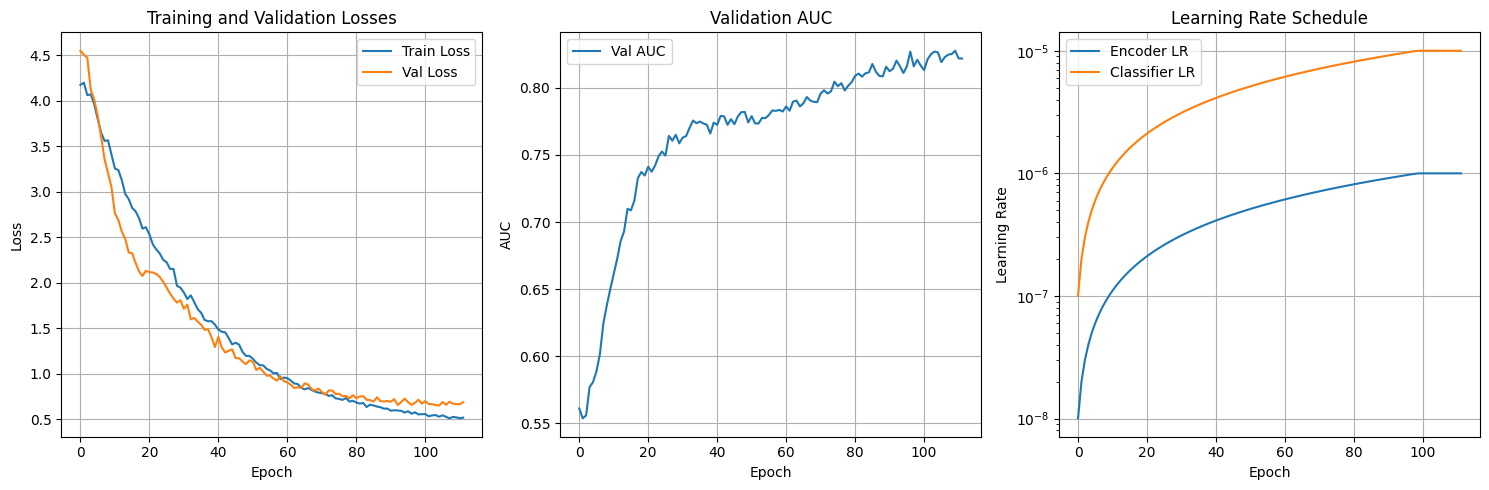

ImprovedMedicalClassifier(
  (encoder): CustomResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (relu): LeakyReLU(negative_slope=0.2, inplace=True)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

In [25]:
import torch
import math
from tqdm import tqdm
from sklearn.metrics import roc_auc_score

# Required imports
import matplotlib.pyplot as plt
from pathlib import Path

# Load the pretrained MaskedAutoencoder model
pretrained_model = MaskedAutoencoder(mask_ratio=0.75).to(device)
checkpoint_path = "/content/drive/MyDrive/data/best_masked_autoencoder.pth"
pretrained_model, _ = load_checkpoint(pretrained_model, checkpoint_path, device)

# Initialize the improved classification model
classification_model = ImprovedMedicalClassifier(pretrained_model=pretrained_model).to(device)

# Create data loaders - use a slightly smaller batch size for better stability
batch_size = 32  # Reduced from 64
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True
)
val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True
)

# Train with improved method
train_classifier_improved(classification_model, train_loader, val_loader, device, num_epochs=500)

# TESTING

<ipython-input-26-fc95ebad340e>:113: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('/content/drive/MyDrive/data/best_classification_model_improved.pt

Starting evaluation...


Testing: 100%|██████████| 28/28 [01:31<00:00,  3.26s/it]



Test Results:
--------------------------------------------------
Loss        : 0.462
Accuracy    : 0.813 (95% CI: 0.787-0.839)
Sensitivity : 0.753 (95% CI: 0.724-0.782)
Specificity : 0.865 (95% CI: 0.842-0.888)
Precision   : 0.827 (95% CI: 0.802-0.853)
NPV         : 0.803 (95% CI: 0.776-0.829)
F1-Score    : 0.789 (95% CI: 0.761-0.816)
AUC         : 0.885 (95% CI: 0.863-0.906)


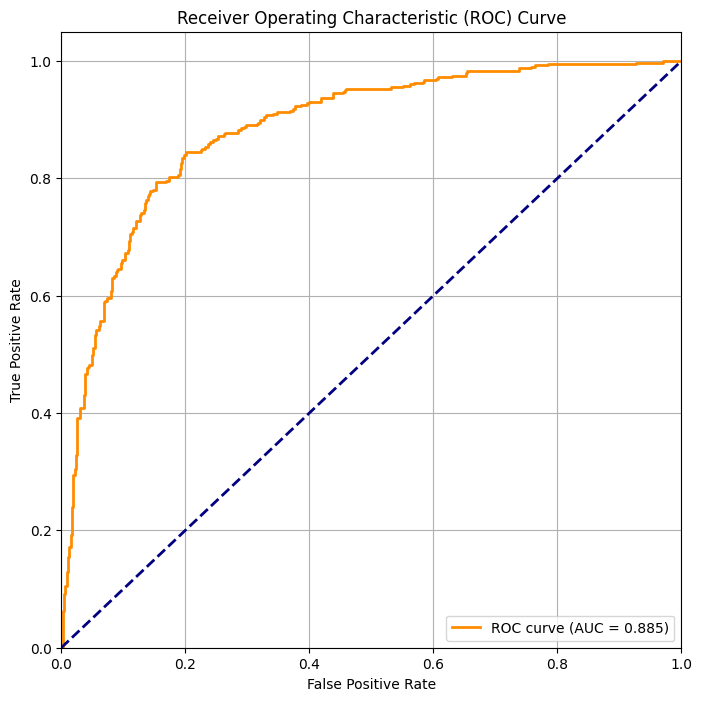

In [26]:
import sklearn.metrics
from IPython import get_ipython
from IPython.display import display

import sklearn.metrics
from IPython import get_ipython
from IPython.display import display

def evaluate_model(model, test_loader, device):
    model.eval()
    all_preds = []
    all_labels = []
    test_loss = 0
    criterion = nn.BCEWithLogitsLoss()

    print("Starting evaluation...")
    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc="Testing"):
            images = images.to(device)
            labels = labels.float().to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs.squeeze(), labels)
            test_loss += loss.item()

            # Store predictions and labels
            # Get predictions for the current batch
            predictions = outputs.squeeze().cpu().numpy()
            labels = labels.cpu().numpy()
            all_preds.extend(predictions)
            all_labels.extend(labels)

    # Convert to numpy arrays
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    # Calculate metrics
    average_loss = test_loss / len(test_loader)
    # Correct way to threshold with BCEWithLogitsLoss
    # Apply sigmoid to all predictions to get probabilities
    sigmoid_preds = torch.sigmoid(torch.tensor(all_preds)).cpu().numpy()
    binary_preds = (sigmoid_preds > 0.5).astype(int)

    # True positives, false positives, etc.
    tp = np.sum((binary_preds == 1) & (all_labels == 1))
    fp = np.sum((binary_preds == 1) & (all_labels == 0))
    tn = np.sum((binary_preds == 0) & (all_labels == 0))
    fn = np.sum((binary_preds == 0) & (all_labels == 1))

    # Calculate metrics
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    npv = tn / (tn + fn) if (tn + fn) > 0 else 0
    f1 = 2 * (precision * sensitivity) / (precision + sensitivity) if (precision + sensitivity) > 0 else 0
    auc = roc_auc_score(all_labels, all_preds)

    # Calculate confidence intervals (95%)
    n = len(all_labels)
    z = 1.96  # 95% confidence interval

    def confidence_interval(p):
        std_err = np.sqrt((p * (1-p)) / n)
        return z * std_err

    metrics = {
        'Loss': f"{average_loss:.3f}",
        'Accuracy': f"{accuracy:.3f} (95% CI: {accuracy-confidence_interval(accuracy):.3f}-{accuracy+confidence_interval(accuracy):.3f})",
        'Sensitivity': f"{sensitivity:.3f} (95% CI: {sensitivity-confidence_interval(sensitivity):.3f}-{sensitivity+confidence_interval(sensitivity):.3f})",
        'Specificity': f"{specificity:.3f} (95% CI: {specificity-confidence_interval(specificity):.3f}-{specificity+confidence_interval(specificity):.3f})",
        'Precision': f"{precision:.3f} (95% CI: {precision-confidence_interval(precision):.3f}-{precision+confidence_interval(precision):.3f})",
        'NPV': f"{npv:.3f} (95% CI: {npv-confidence_interval(npv):.3f}-{npv+confidence_interval(npv):.3f})",
        'F1-Score': f"{f1:.3f} (95% CI: {f1-confidence_interval(f1):.3f}-{f1+confidence_interval(f1):.3f})",
        'AUC': f"{auc:.3f} (95% CI: {auc-confidence_interval(auc):.3f}-{auc+confidence_interval(auc):.3f})"
    }

    # Print results in a formatted way
    print("\nTest Results:")
    print("-" * 50)
    for metric, value in metrics.items():
        print(f"{metric:12s}: {value}")

    # Plot ROC curve
    fpr, tpr, _ = sklearn.metrics.roc_curve(all_labels, all_preds)
    plt.figure(figsize=(8, 8))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {auc:.3f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.savefig('roc_curve.png')
    plt.show()

    return metrics

# Usage
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

# Load best model
best_model = ImprovedMedicalClassifier(pretrained_model=pretrained_model)  # Remove .to(device) here
checkpoint = torch.load('/content/drive/MyDrive/data/best_classification_model_improved.pth', map_location=device)
best_model.load_state_dict(checkpoint['model_state_dict'])

# Move the model to the device after loading the state_dict
best_model.to(device)

# Evaluate
metrics = evaluate_model(best_model, test_loader, device)